# Plotting Your Data
----
To start out, you'll want to load your data from a file using numpy.  Make sure you also get the angle step right here, or else things could turn out really strange.

In [113]:
import numpy as np
from skimage.measure import block_reduce
data_filename = "Lastscan.csv"


import matplotlib.pyplot as plt
from scipy import optimize
from pandas import DataFrame
import math
import scipy.optimize as opt
from scipy import integrate



In [114]:
data = np.loadtxt(data_filename,delimiter=",")   
angles = []
angle_step = 10
for i in range(len(data)):
    angles.append(i*angle_step)
print(angles)
len(angles)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]


19

## Data Filtering

Using scikit-image block_reduce function.

In [115]:
#arr_reduced = block_reduce(data, block_size=(1,5), func=np.mean, cval=np.mean(data))

Now that that's loaded, we'll us matplotlib's `imshow` command to display our data as a 2d image with intensity coded as color.  

`extent` here is used to define the `x` and `y` axis start and end values

`aspect="auto"` makes the plot square instead of long & thin.

<IPython.core.display.Javascript object>


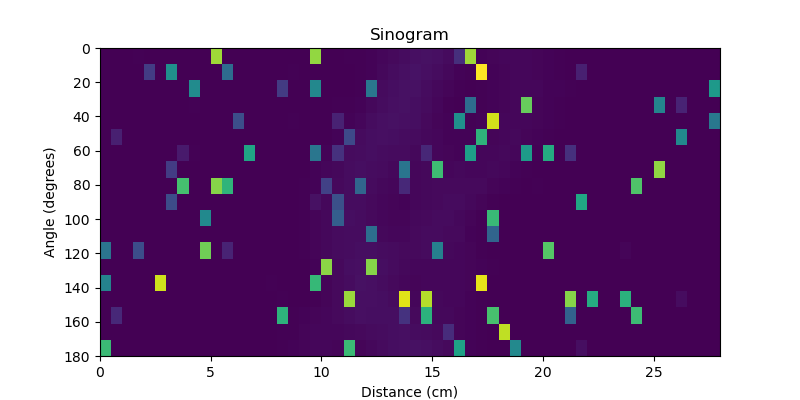

In [116]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig,ax = plt.subplots(figsize = (8,4))
start_dist = 0
end_dist = 28
start_angle = 0
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax.imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Angle (degrees)")
ax.set_title("Sinogram");
fig.savefig('3source-sinogram.png')

In [117]:

def smear(array,x,y):
    adjacent = []
    xsequence = [-1,-1,-1,0,0,1,1,1]
    ysequence = [-1,0,1,-1,1,-1,0,1]
    for index,item in enumerate(xsequence):
        try:
            adjacent.append(array[x+xsequence[index]][y+ysequence[index]])
        except:
            pass
    return np.median(adjacent)

cutoff_threshold = 1.5e4
data2 = np.zeros_like(data)
for i in range(len(data)):
    for j in range(len(data[0])):
        if(data[i][j]>cutoff_threshold ):
            data2[i][j] = smear(data,i,j)
        else:
            data2[i][j] = data[i][j]
data = data2

Now we have an inverse problem:  We know what the intensity of our source looks like as a function of distance and angle, but we want to know it in terms of x and y position.

There are a number of ways we can go about doing this, but we'll start with the simplest first: projecting out our slices along the line of response for the detectors, rotating these projections by their associated angles, and then combining all these together to get a composite plot.

To project out out slices, we'll use `np.outer` to do an outer product; this turns our 1d slices into 2d matricies.

The doce below does this for each slice in our data, and plots the results for the first and second slices.

<IPython.core.display.Javascript object>


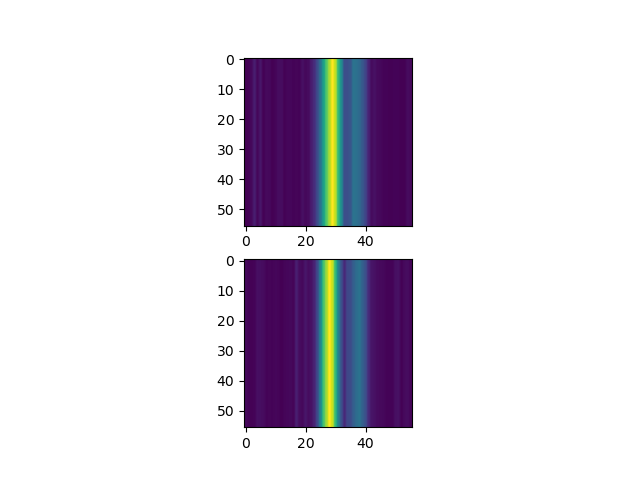

In [118]:
from scipy import ndimage
expand_vec = np.ones(data[0].size)  # this is used to get us a square matrix
expanded_data = []
for item in data:
    expanded_data.append(np.outer(expand_vec,item))
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(expanded_data[0])
ay.imshow(expanded_data[1])

Okay, we've made 2d representations of our data.  Now how do we rotate them?  Instead of writing code to do matrix rotation ourselves, we'll use scipy's `ndimage` library.  Unless you manually want to write a matrix rotation algorithm.  I'm not your boss, knock yourself out.

<IPython.core.display.Javascript object>


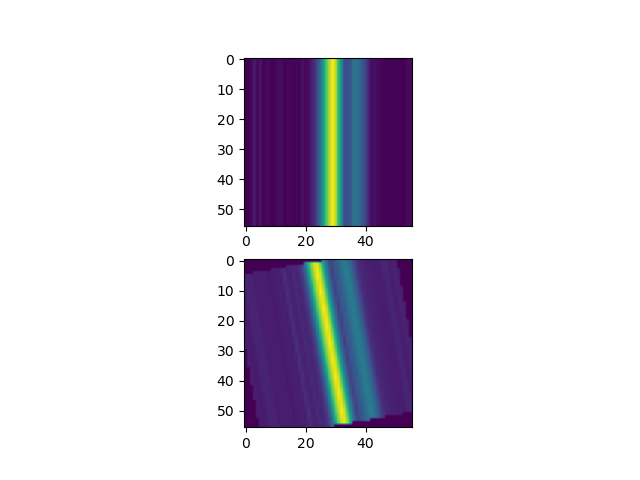

In [119]:
rotated_data = []
for index, item in enumerate(expanded_data):
    rotated_data.append(ndimage.rotate(item,angles[index],reshape=False,order=1)) # we want Numpy to keep our square, 2d matricies.
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(rotated_data[0])
ay.imshow(rotated_data[1])


The rotated part has some bad aliasing going on, but it more-or-less captures the results of our third scan.  We'll show how to reduce that a bit later, but for now let's start recombining data!

To do this, we'll make a composite image by multiplying each of these expanded & rotated slices together.  Locations where we don't see many coincidences at any angle will end up with low counts, and locations with lots of coincidences at similar angles will end up with high counts.  It may be easier to see what this looks like, so let's start by recombining just the first and third slices.

We'll also normalize the data by taking the `nth` root, where `n` is the number of slices we're using.  The units would end up being something insane if we didn't do this.

<IPython.core.display.Javascript object>


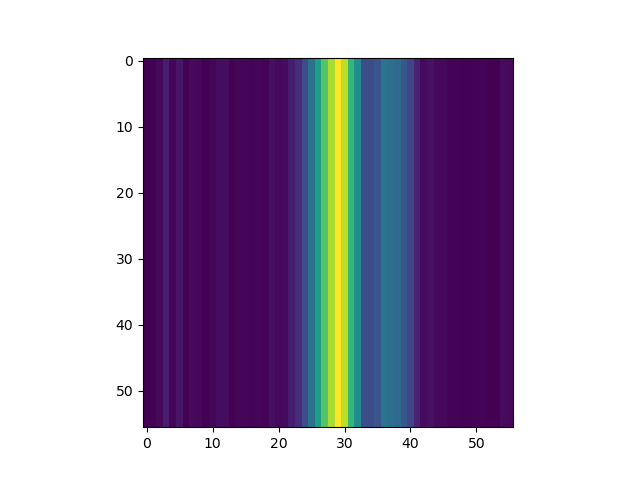

In [120]:
fig, ax = plt.subplots()
ax.imshow(rotated_data[0])

<IPython.core.display.Javascript object>


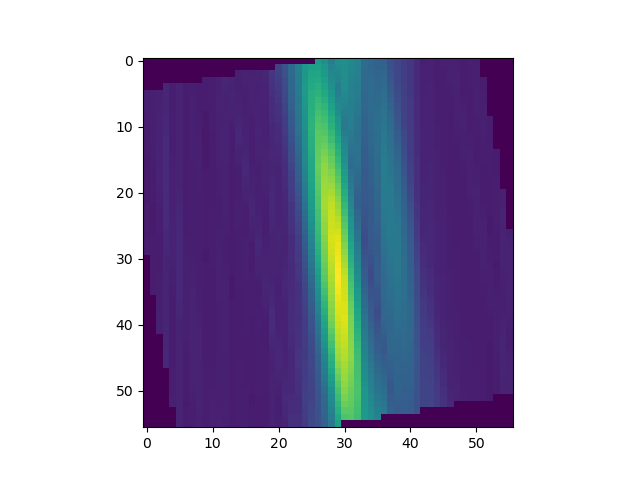

In [121]:
composite = rotated_data[0] * rotated_data[1]
normalized = np.power(composite,(1/2))

fig, ax = plt.subplots()
ax.imshow(normalized)

You should now have some smears or blobs in your image instead of just straight lines.  Let's go ahead and go through the entire thing and see what we get.

<IPython.core.display.Javascript object>


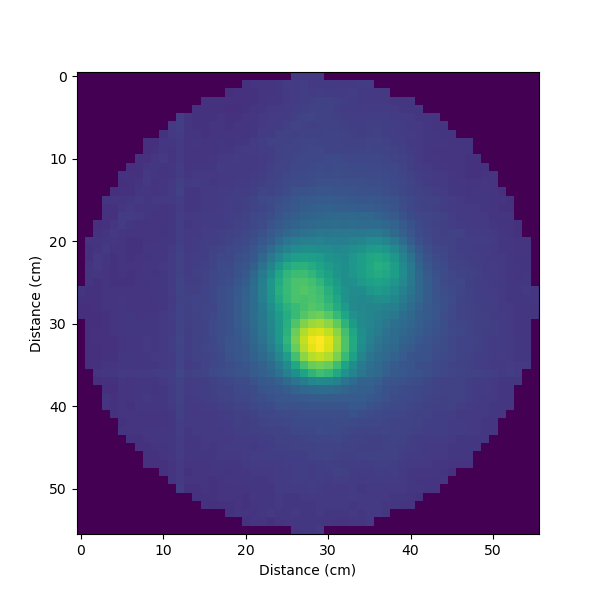

In [122]:
composite = np.ones_like(rotated_data[0]) # We need a matrix full of 1s to start out with, we can't multiply an empty matrix with anything.
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(normalized)
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Distance (cm)")



fig.savefig('3_source_sinogram.png')

While likely quite blurry, you should have something that now at least vaguely resembles a few point sources.  Congratulations, you've now got the basics down!

# Peak Detection

In [123]:
from findpeaks import findpeaks

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Fin.


<IPython.core.display.Javascript object>


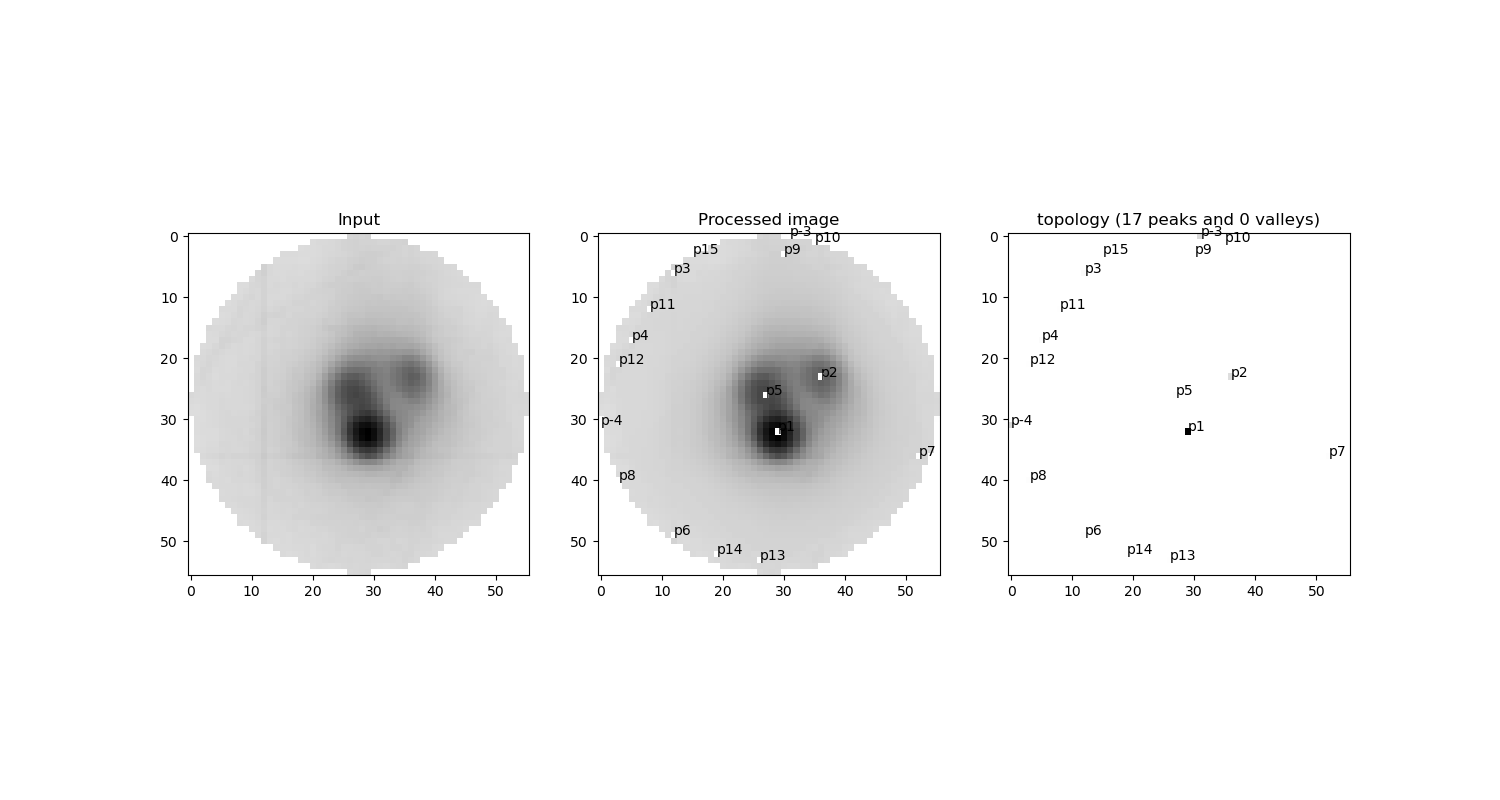

(<AxesSubplot:title={'center':'Input'}>,
 <AxesSubplot:title={'center':'Processed image'}>,
 <AxesSubplot:title={'center':'topology (17 peaks and 0 valleys)'}>)

In [124]:
fp = findpeaks(method='topology')
results = fp.fit(normalized)
fp.plot()

In [125]:
results['persistence']

x   y  birth_level  death_level  score   peak  valley
0   29  32          255            0    255   True   False
1   36  23          160          127     33   True   False
2   12   6           46           40      6   True   False
3    5  17           44           40      4   True   False
4   27  26          186          183      3   True   False
5   12  49           43           40      3   True   False
6   52  36           46           44      2   True   False
7    3  40           39           37      2   True   False
11   3  21           42           41      1   True   False
14  15   3           37           36      1   True   False
12  26  53           42           41      1   True   False
13  19  52           39           38      1   True   False
10   8  12           42           41      1   True   False
9   35   1           45           44      1   True   False
8   30   3           49           48      1   True   False
27  16   6           40           40      0   True   False
1   55  31            0            0      0  False    True
0    0   0            0            0      0  False    True
35   0   0            0            0      0   True   False
34   5  12           37           37      0   True   False
33   1  20           38           38      0   True   False
32   3  15           38           38      0   True   False
31  21   1           38           38      0   True   False
30  54  21           39           39      0   True   False
29   3  36           40           40      0   True   False
28  49  14           40           40      0   True   False
20  17  11           42           42      0   True   False
26   6  15           41           41      0   True   False
25  10  10           41           41      0   True   False
24  14  10           41           41      0   True   False
23  17   8           41           41      0   True   False
22  12  13           42           42      0   True   False
21  15  13           42           42      0   True   False
19  33   2           46           46      0   True   False
18  37   5           47           47      0   True   False
17  12  28           48           48      0   True   False
16  28   3           48           48      0   True   False
15  28   5           49           49      0   True   False
2   31   0            0          -37    -37  False    True
3    0  31            0          -37    -37  False    True

The goal of the findpeaks function is to ensure our peaks are statistically significant candidates and to find ball park what is the point of highest count rate. We now run two Gaussian fits for each of the peaks to find its precise location and uncertainty.

# Gaussian Fits

## Peak 1

In [174]:
def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), -1, -1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), -1, -1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    pfcov = cov[0,1]
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq, dof

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def gaussianfunc_bg(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))+p[3]

def n_avg_2d(list, i):
    sum = 0
    div = 0
    for offset_i in [-1,0, 1]:
        new_i = i + offset_i
        if (new_i >= 0 and new_i < len(list)):
            sum += list[new_i]
            div += 1
    avg = (sum-list[i]) / (div-1)
    return avg

def smoothing_2d(list):
    for x in range(0,len(list)):
        if list[x] > 1.25*n_avg(list,x) or list[x] < 0.80*n_avg(list,x):
            list[x] = n_avg(list,x)
    return(list)

In [188]:
x = []
step = 0.5
while step <= 28:
    x.append(step)
    step += 0.5
    
x = np.array(x)

<IPython.core.display.Javascript object>


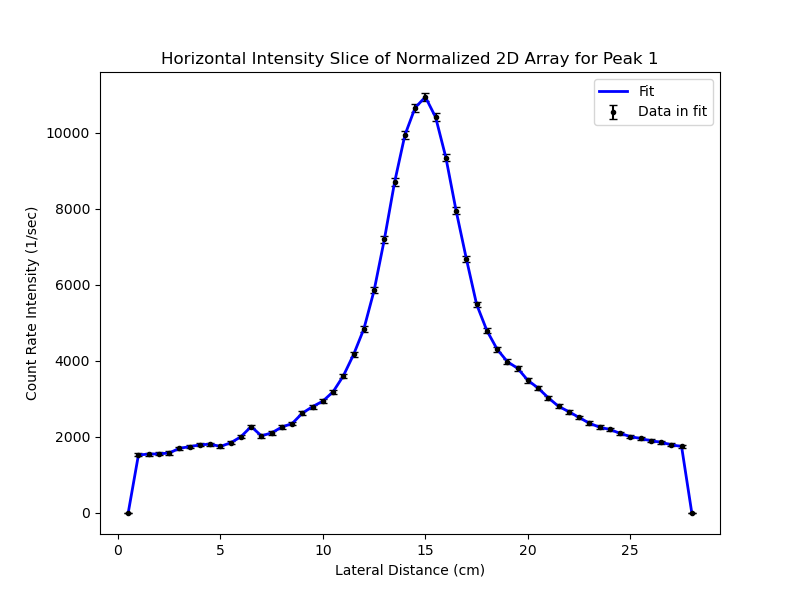

In [189]:
y = normalized[32] # row 32 of matrix
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Horizontal Intensity Slice of Normalized 2D Array for Peak 1')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()



Converged with chi-squared 26.19
Number of degrees of freedom, dof = 12.00
Reduced chi-squared 2.18

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.000e+04                | 3.386e+04                | 5.791e+02               
1           | 1.500e+01                | 1.491e+01                | 1.070e-02               
2           | 1.700e+00                | 1.717e+00                | 2.062e-02               
3           | 1.000e+03                | 3.000e+03                | 6.361e+01               


<IPython.core.display.Javascript object>


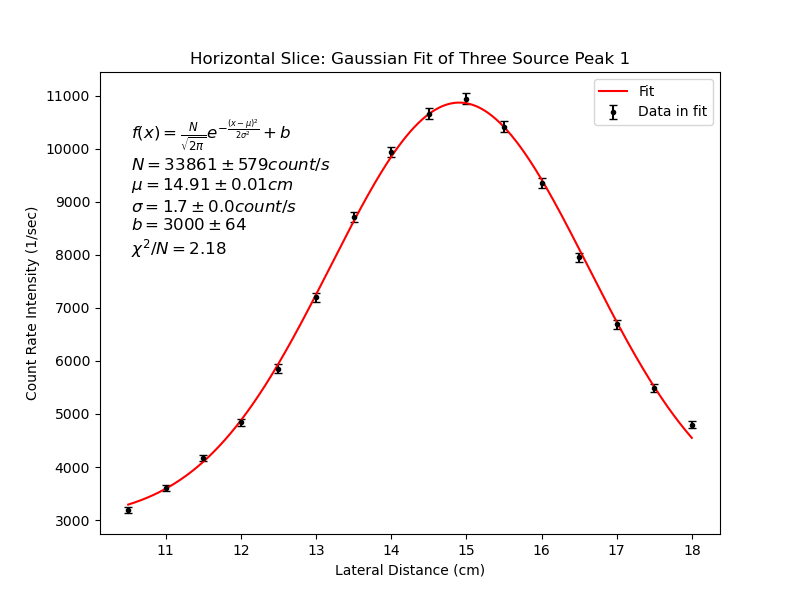

[10.5       10.5015003 10.5030006 ... 17.9969994 17.9984997 18.       ]


In [190]:
guess = [30000,15,1.7,1000]

min_value = 20
max_value = 36

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (8,6))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} cm$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Horizontal Slice: Gaussian Fit of Three Source Peak 1')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('3source-peak1-horizontal.png')

<IPython.core.display.Javascript object>


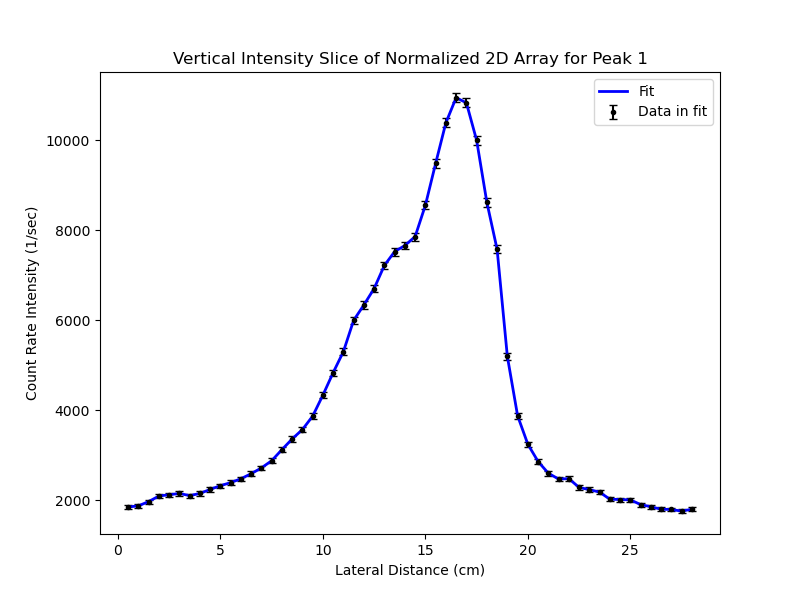

In [191]:
y=normalized[ :,29]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Vertical Intensity Slice of Normalized 2D Array for Peak 1')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()



Converged with chi-squared 8.88
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 2.22

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+04                | 9.405e+03                | 1.057e+03               
1           | 1.600e+01                | 1.659e+01                | 2.191e-02               
2           | 1.000e+00                | 1.028e+00                | 6.565e-02               
3           | 7.000e+03                | 7.379e+03                | 2.155e+02               


<IPython.core.display.Javascript object>


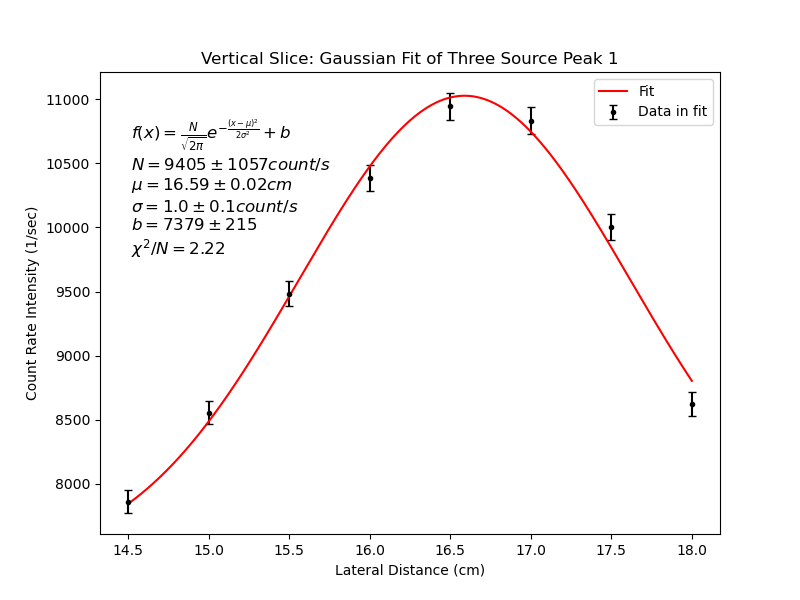

[14.5        14.50070014 14.50140028 ... 17.99859972 17.99929986
 18.        ]


In [192]:
guess = [10000,16,1,7000]

min_value = 28
max_value = 36

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (8,6))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')



#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+b$\n'  
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} cm$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Vertical Slice: Gaussian Fit of Three Source Peak 1')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('3source-peak1-vertical.png')

## Peak 2

<IPython.core.display.Javascript object>


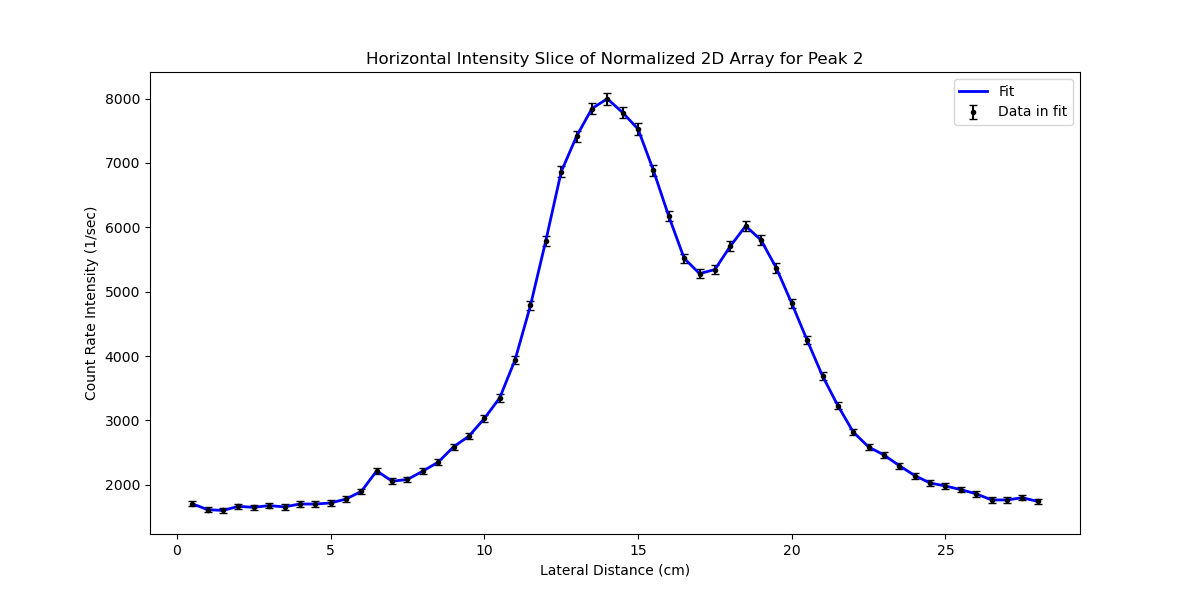

In [193]:
y = normalized[26]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (12,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Horizontal Intensity Slice of Normalized 2D Array for Peak 2')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()

fig.savefig('3source_horizontal.png')


Converged with chi-squared 79.07
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 9.88

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+04                | 2.010e+04                | 3.022e+03               
1           | 1.600e+01                | 1.415e+01                | 1.967e-02               
2           | 2.000e+00                | 1.824e+00                | 1.321e-01               
3           | 1.000e+01                | 3.631e+03                | 3.724e+02               


<IPython.core.display.Javascript object>


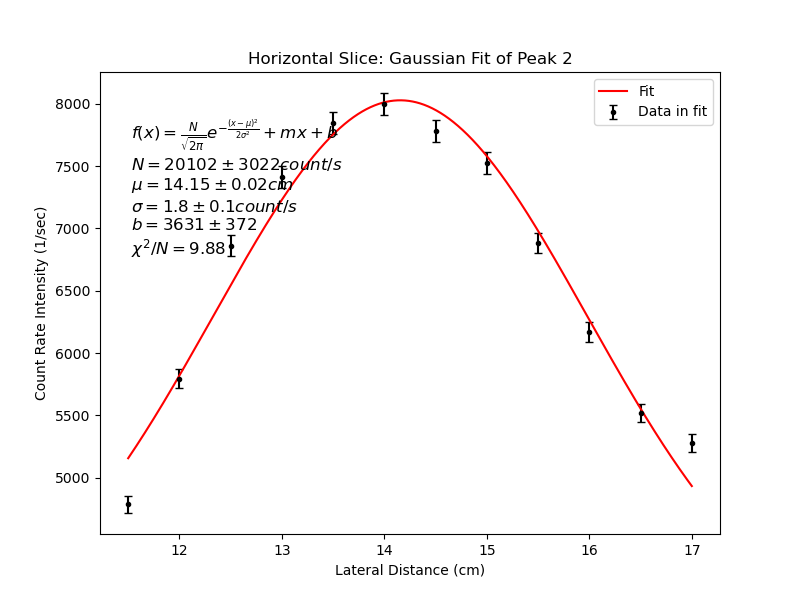

[11.5        11.50110022 11.50220044 ... 16.99779956 16.99889978
 17.        ]


In [194]:
guess = [10000,16,2,10]

min_value = 22
max_value = 34

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (8,6))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} cm$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Horizontal Slice: Gaussian Fit of Peak 2')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('3source-peak2-horizontal.png')

<IPython.core.display.Javascript object>


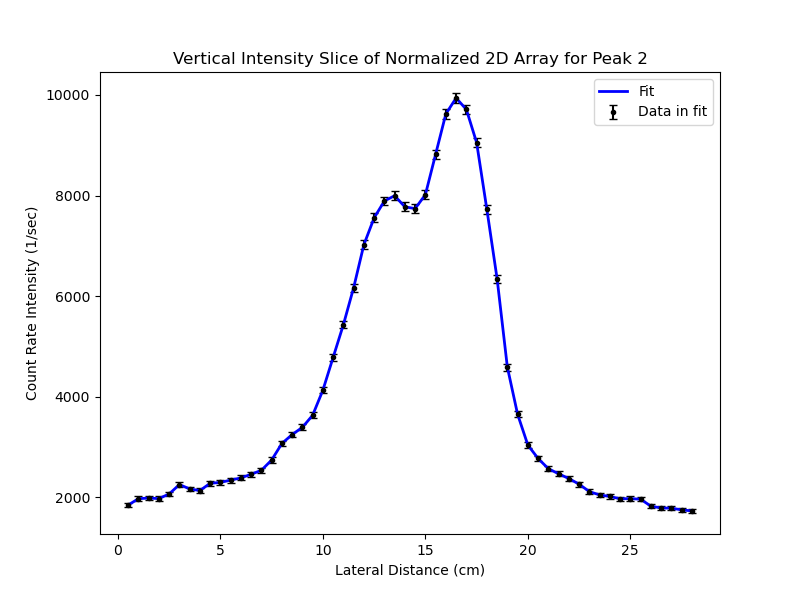

In [195]:

y=normalized[ :,27]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Vertical Intensity Slice of Normalized 2D Array for Peak 2')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()


Converged with chi-squared 1.46
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 0.37

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 2.300e+04                | 2.383e+04                | 5.731e+03               
1           | 1.300e+01                | 1.336e+01                | 6.840e-02               
2           | 2.000e+00                | 1.941e+00                | 2.340e-01               
3           | 2.000e+03                | 3.119e+03                | 6.219e+02               


<IPython.core.display.Javascript object>


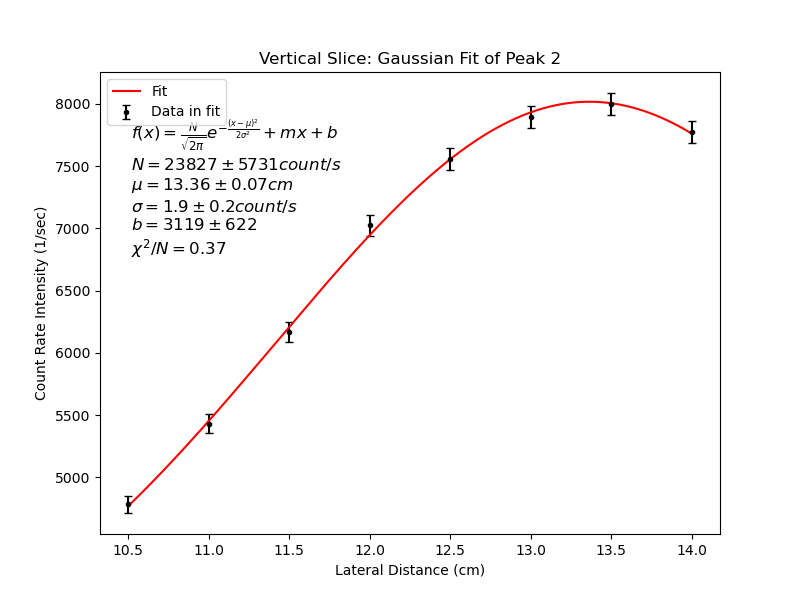

[10.5        10.50070014 10.50140028 ... 13.99859972 13.99929986
 14.        ]


In [196]:
guess = [23000,13,2,2000]

min_value = 20
max_value = 28

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (8,6))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} cm$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Vertical Slice: Gaussian Fit of Peak 2')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('3source-peak2-vertical.png')

## Peak 3

<IPython.core.display.Javascript object>


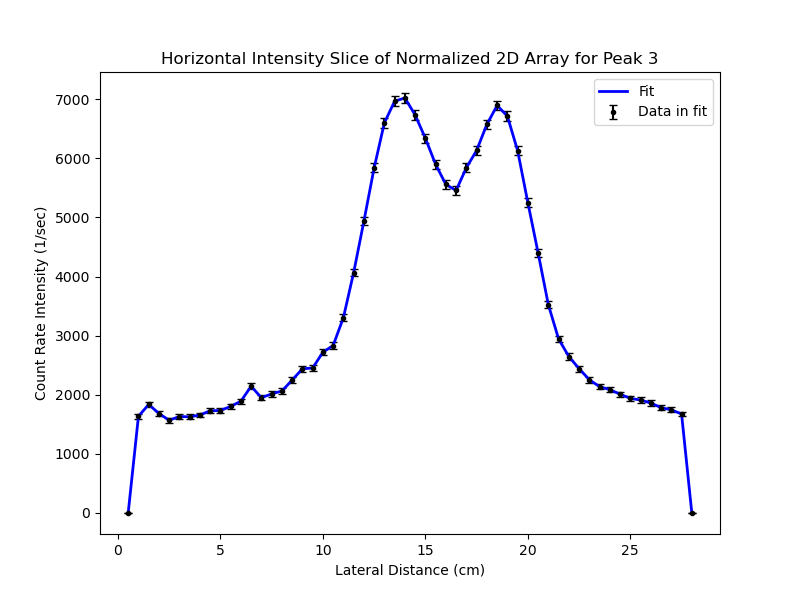

In [197]:
y = normalized[23]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Horizontal Intensity Slice of Normalized 2D Array for Peak 3')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()



Converged with chi-squared 2.34
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 0.58

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 8.000e+03                | 2.453e+04                | 4.954e+03               
1           | 1.800e+01                | 1.851e+01                | 3.068e-02               
2           | 2.000e+00                | 1.800e+00                | 1.685e-01               
3           | 2.000e+03                | 1.440e+03                | 6.249e+02               


<IPython.core.display.Javascript object>


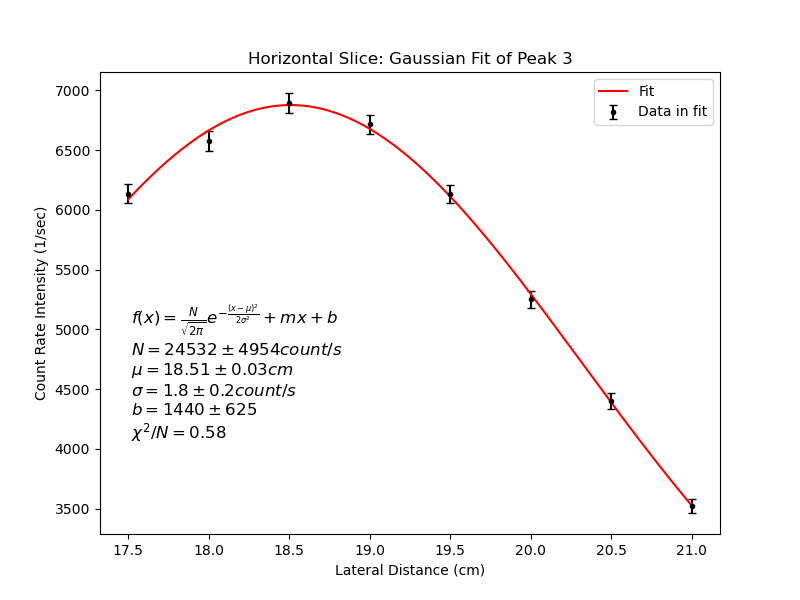

[17.5        17.50070014 17.50140028 ... 20.99859972 20.99929986
 21.        ]


In [198]:
guess = [8000,18,2,2000]

min_value = 34
max_value = 42

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (8,6))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} cm$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.50, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Horizontal Slice: Gaussian Fit of Peak 3')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('3source-peak3-horizontal.png')

<IPython.core.display.Javascript object>


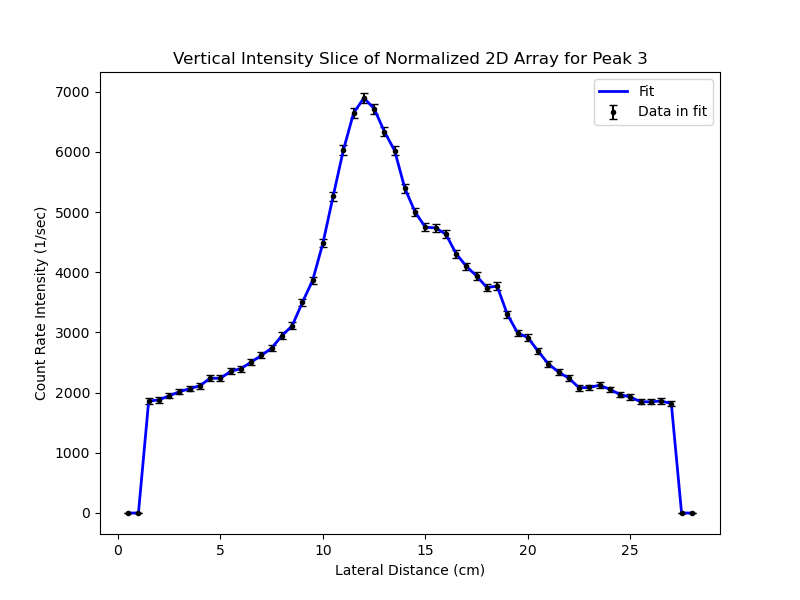

In [199]:

y = normalized[:,36]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Vertical Intensity Slice of Normalized 2D Array for Peak 3')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()


Converged with chi-squared 13.64
Number of degrees of freedom, dof = 6.00
Reduced chi-squared 2.27

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 2.300e+04                | 2.679e+04                | 6.032e+03               
1           | 1.000e+01                | 1.225e+01                | 2.424e-02               
2           | 2.000e+00                | 2.078e+00                | 2.024e-01               
3           | 3.000e+01                | 1.699e+03                | 6.863e+02               


<IPython.core.display.Javascript object>


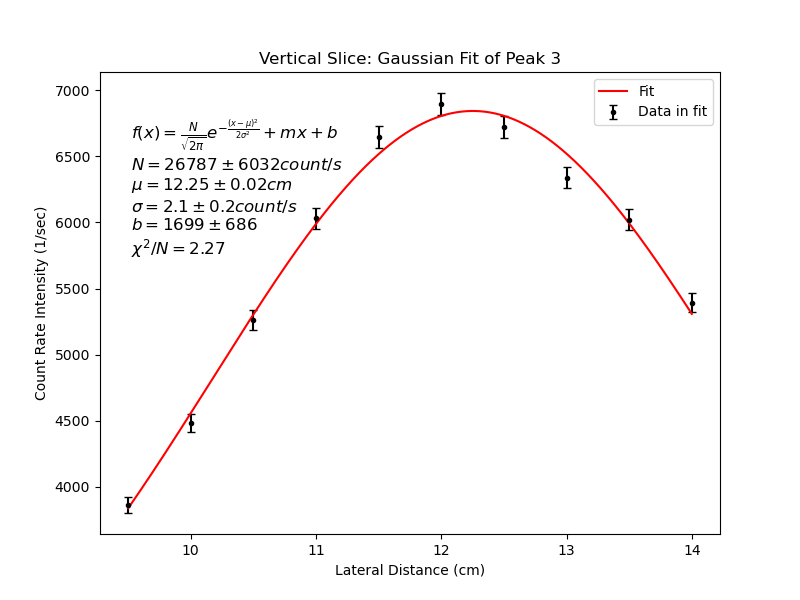

[ 9.5         9.50090018  9.50180036 ... 13.99819964 13.99909982
 14.        ]


In [200]:
guess = [23000,10,2,30]

min_value = 18
max_value = 28

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (8,6))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} cm$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Vertical Slice: Gaussian Fit of Peak 3')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('3source-peak3-vertical.png')

# Alternate Plot Types
----
We can also make contour plots, showing regions of equal intensity.

<IPython.core.display.Javascript object>


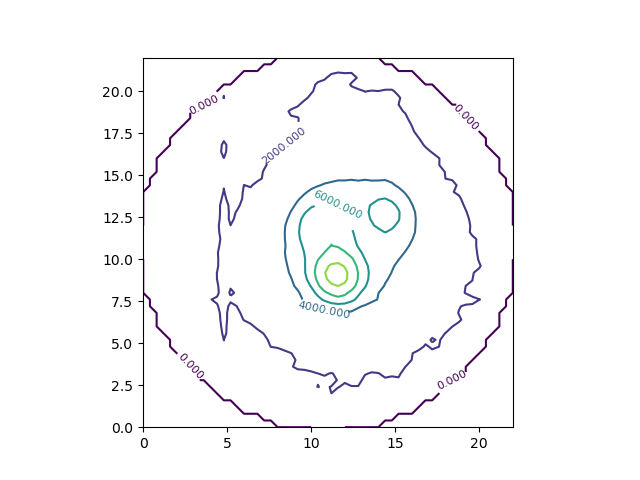

In [168]:
fig, ax = plt.subplots()

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot

num_lines = 6
flipped = normalized[::-1] # This is Python sorcery that flips the data vertically so that it matches the other plots.

p = ax.contour(X, Y, flipped,num_lines)
ax.clabel(p, inline=True, fontsize=8) # This adds numbers to contours
ax.set_aspect('equal')

Another useful option is to make a fully 3d projection

<IPython.core.display.Javascript object>


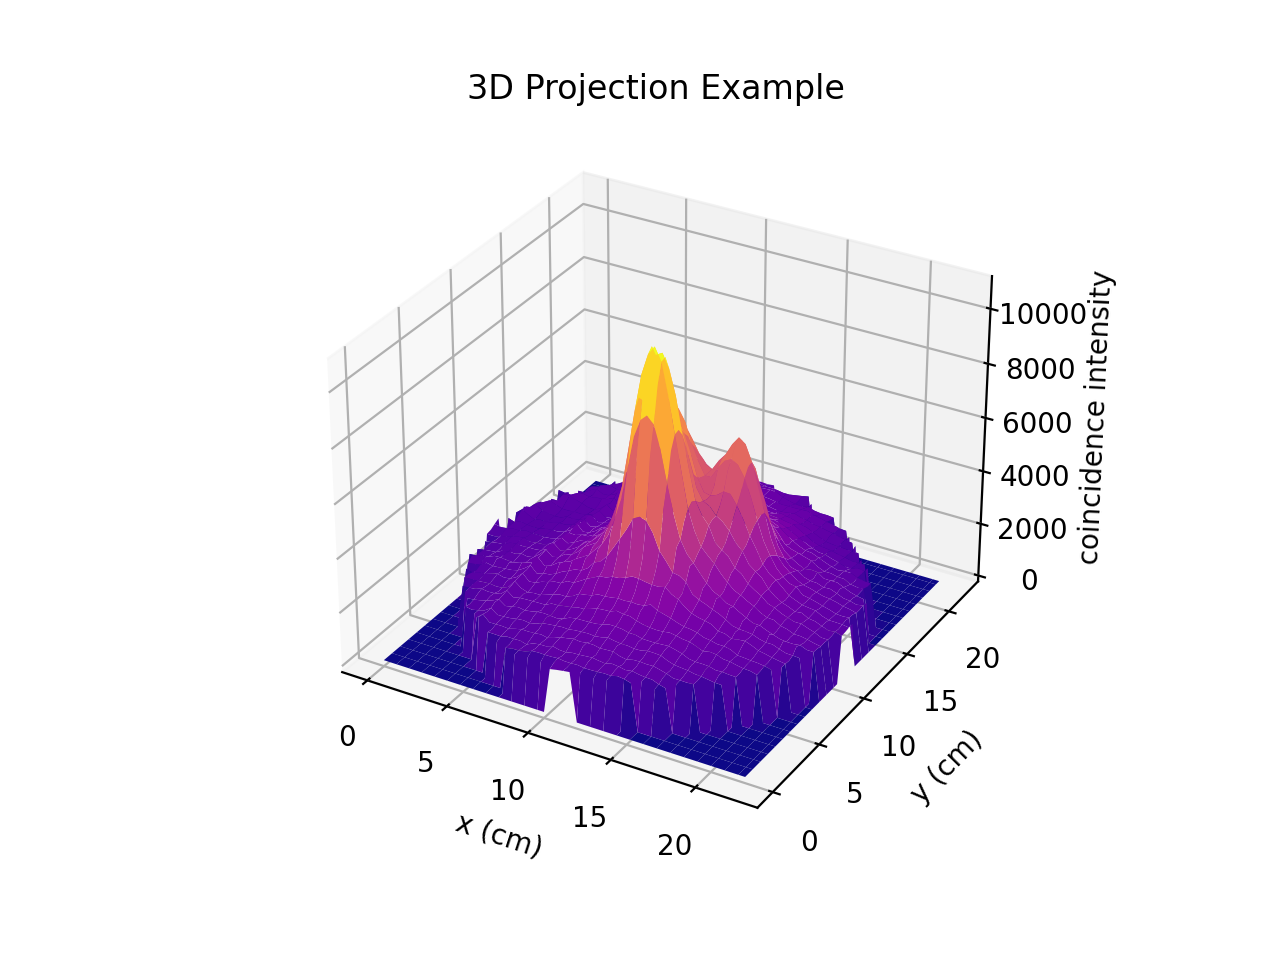

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot

ax.plot_surface(X, Y, flipped,cmap='plasma') #color maps are not required
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('coincidence intensity')
ax.set_title('3D Projection Example');

We can also do this for each of our slices, giving a 3d view of how our reconstruction step-by-step.

<IPython.core.display.Javascript object>


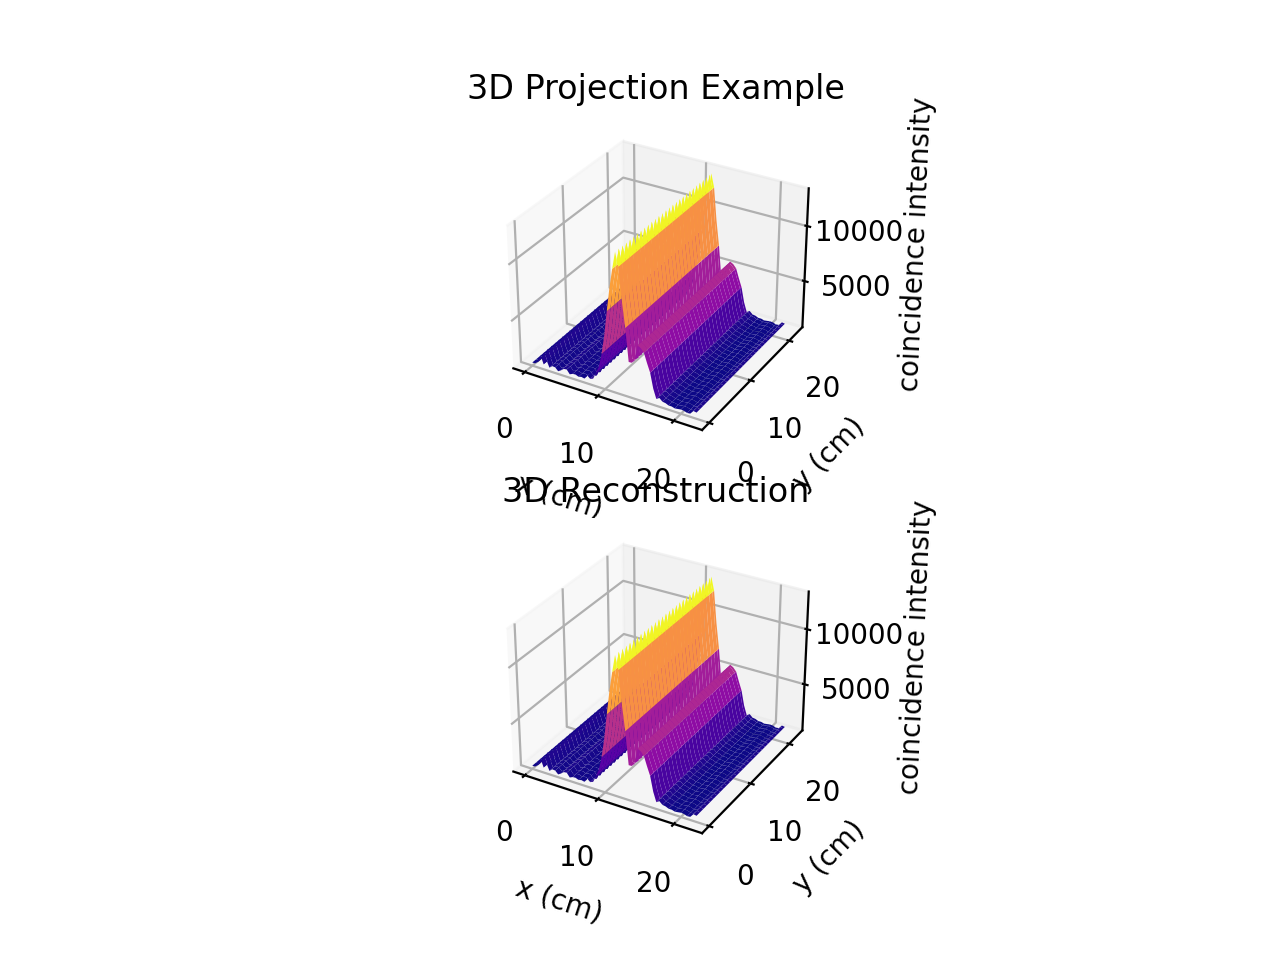

<IPython.core.display.Javascript object>


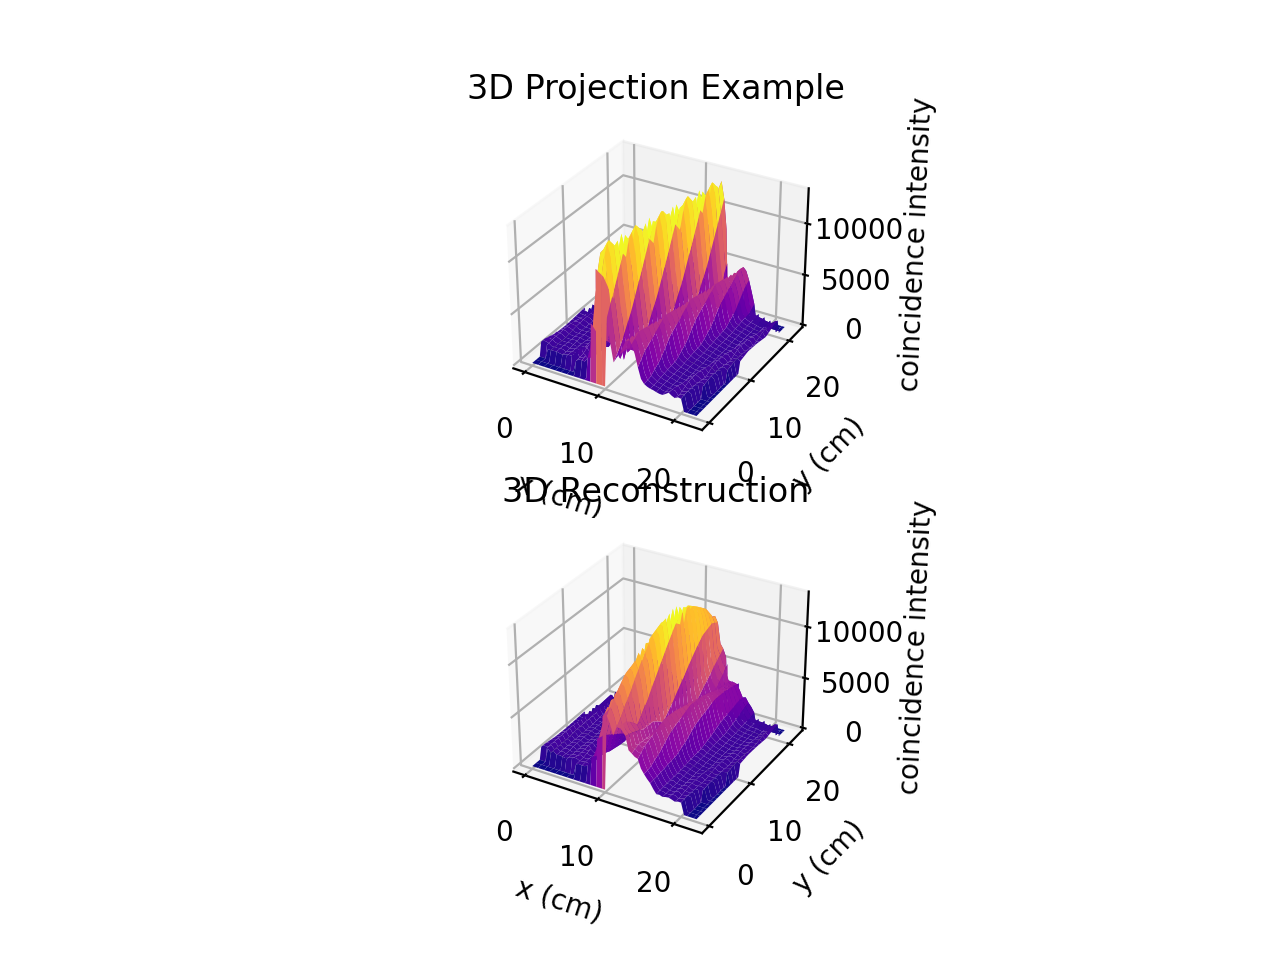

<IPython.core.display.Javascript object>


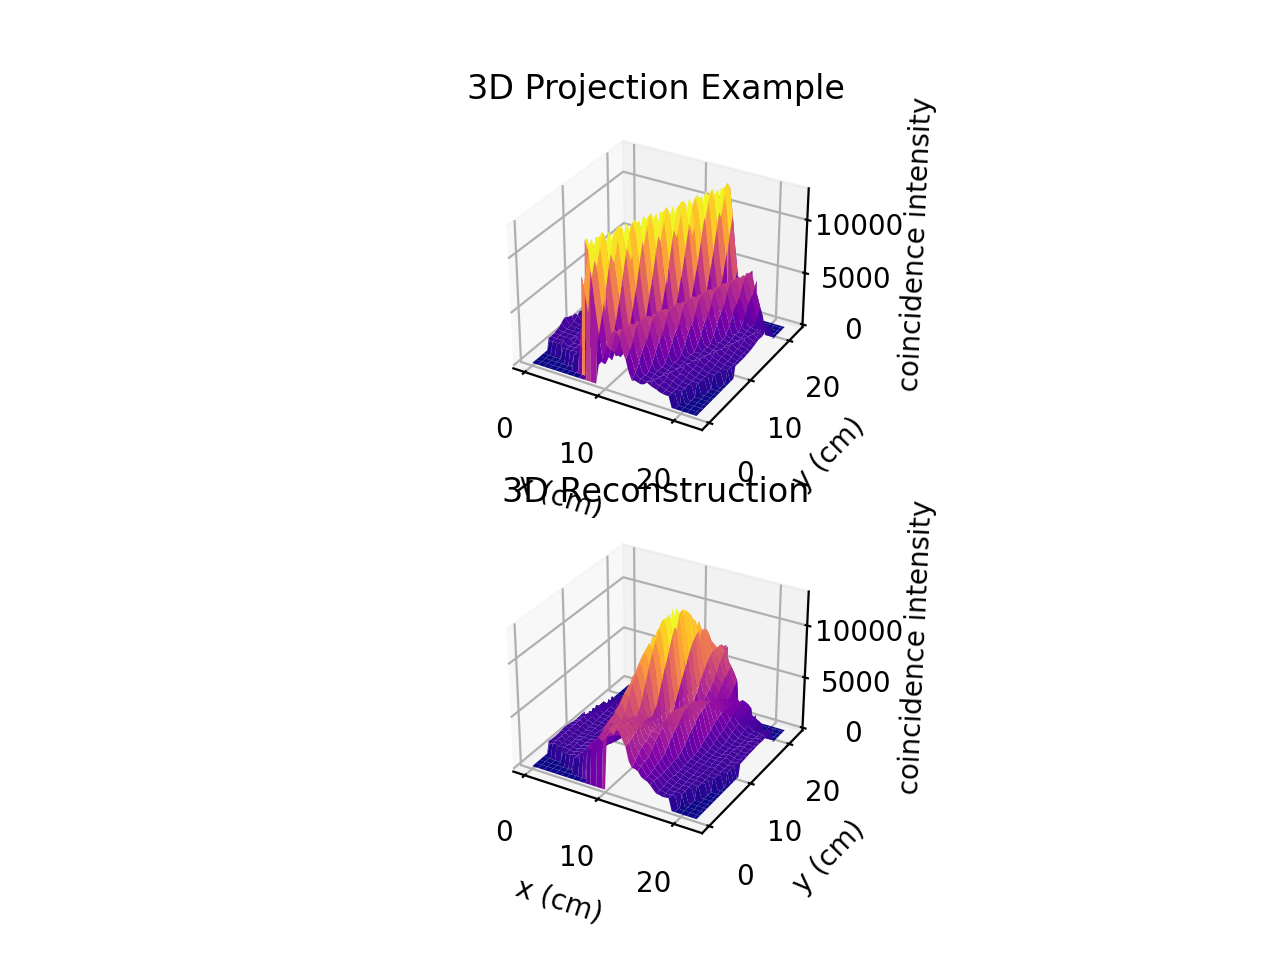

<IPython.core.display.Javascript object>


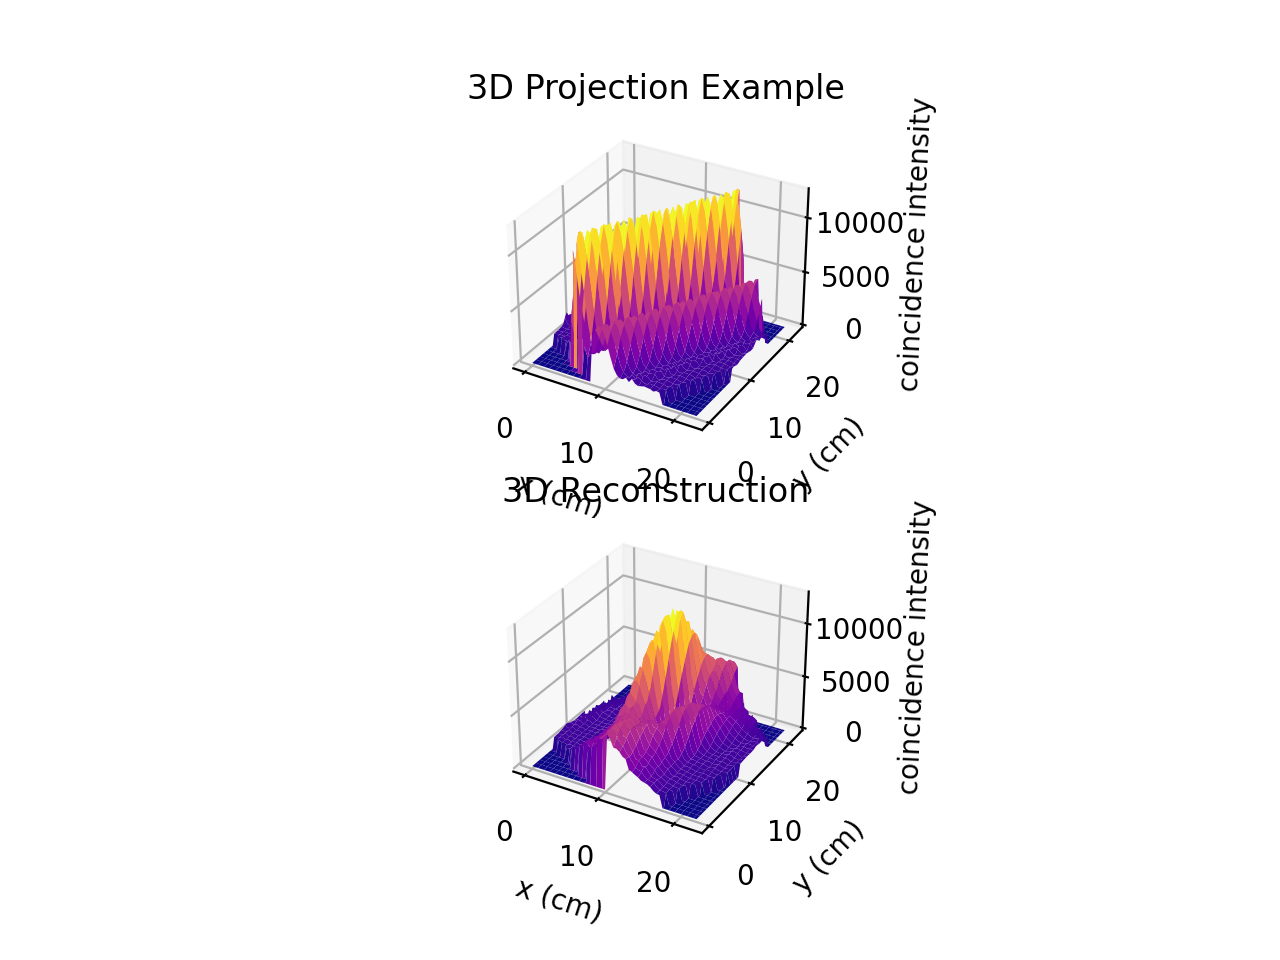

<IPython.core.display.Javascript object>


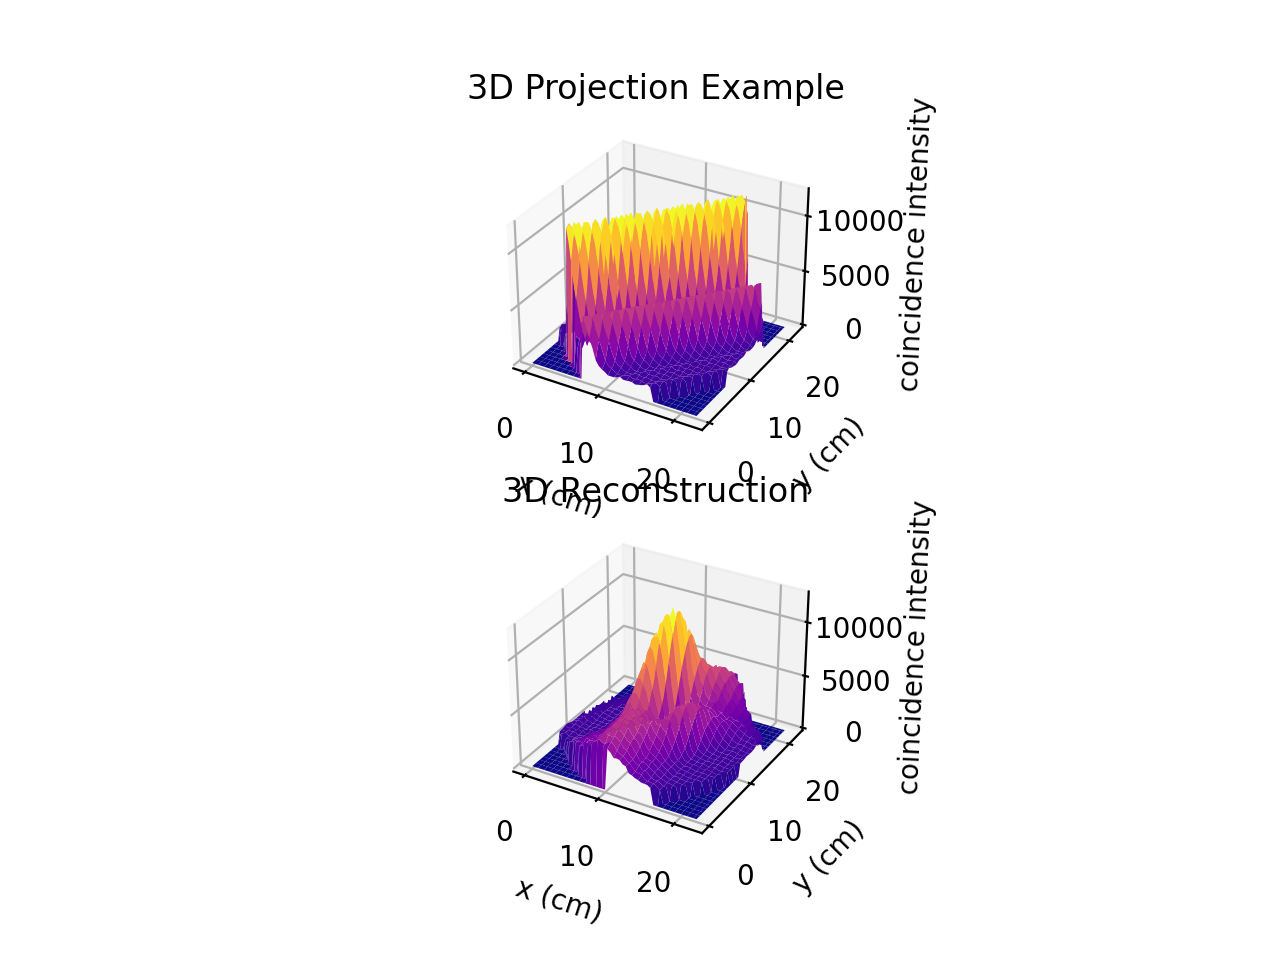

<IPython.core.display.Javascript object>


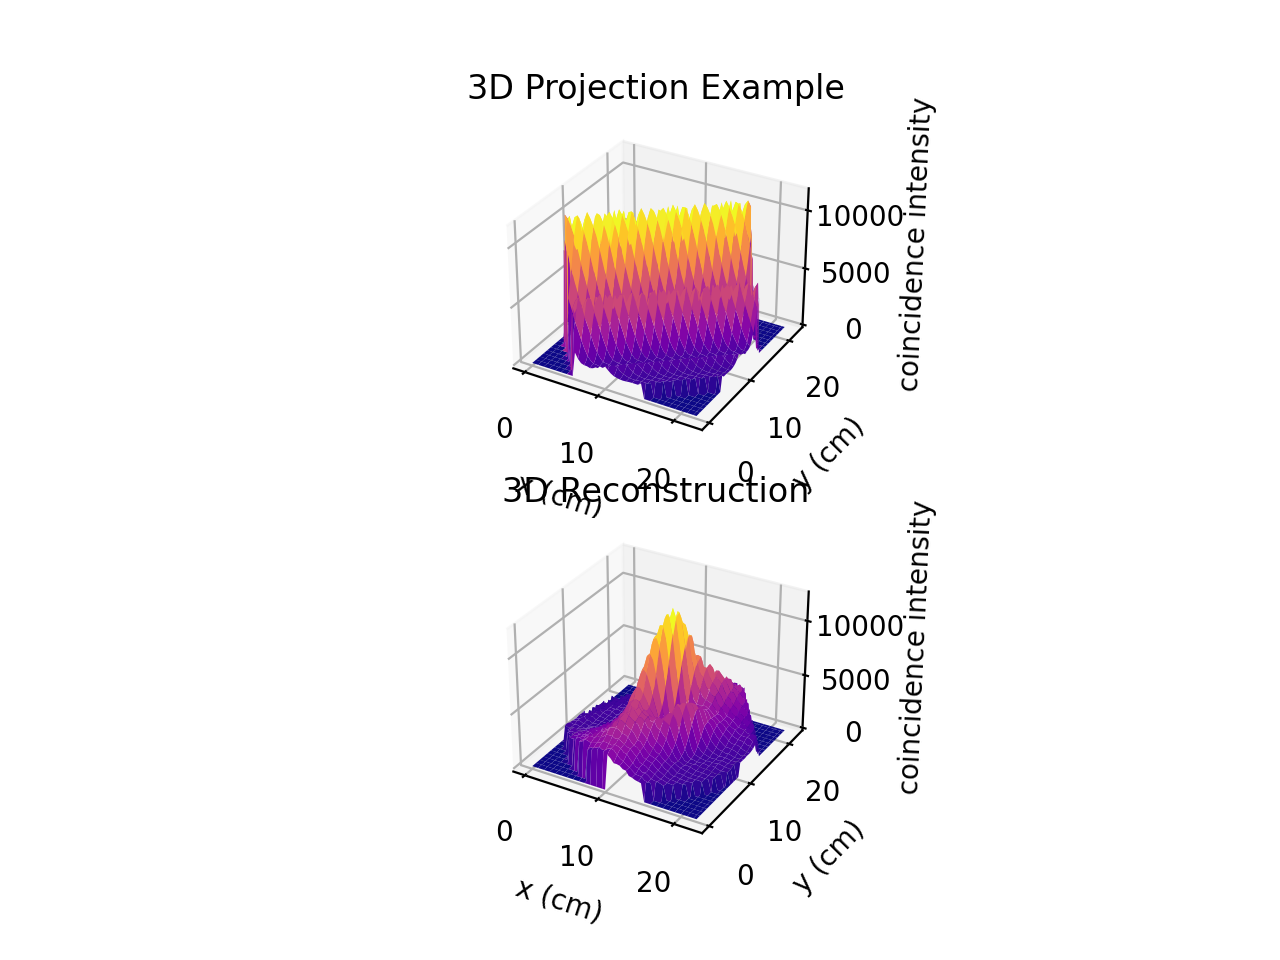

<IPython.core.display.Javascript object>


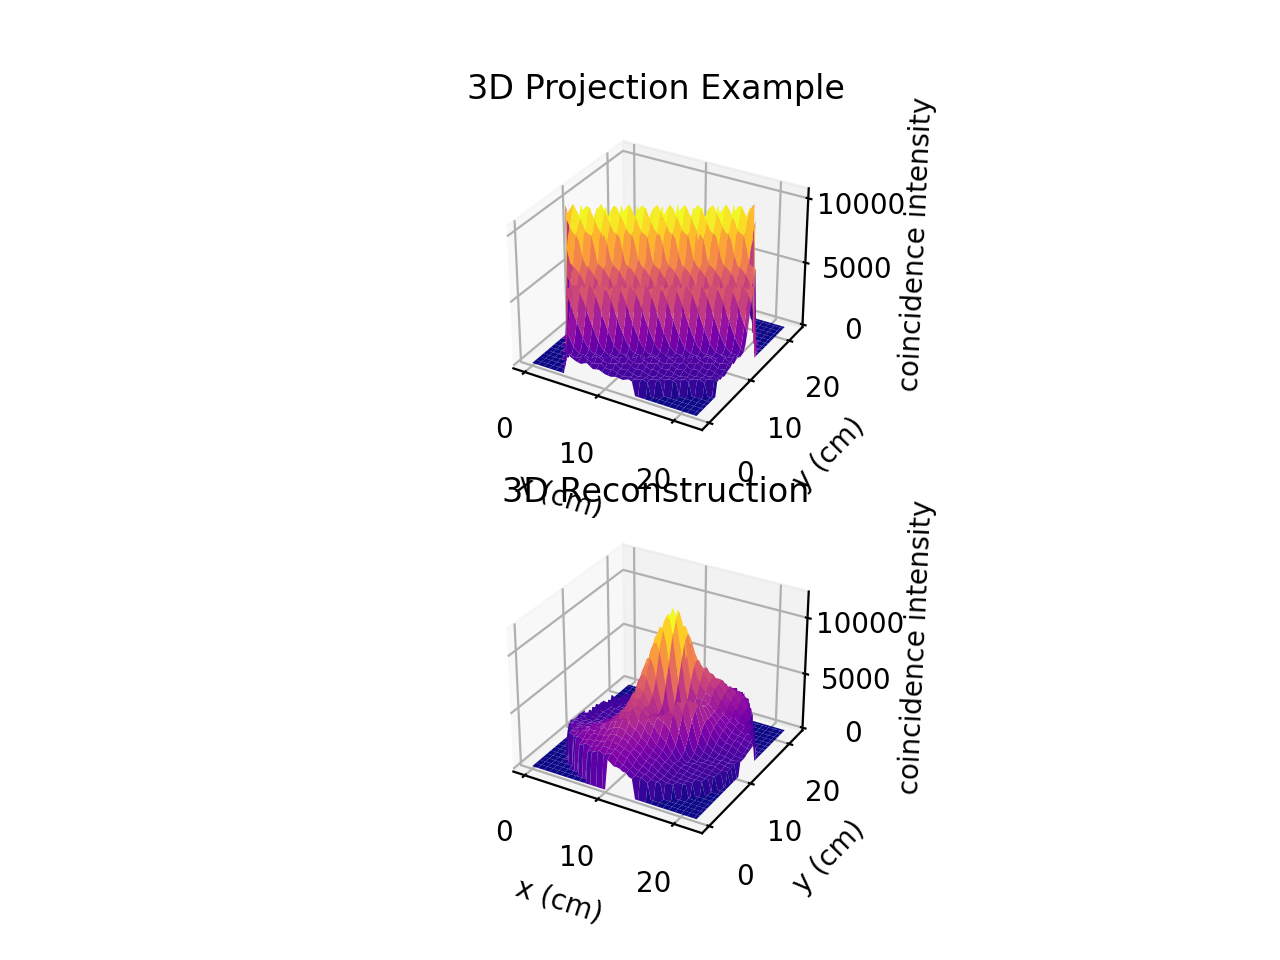

<IPython.core.display.Javascript object>


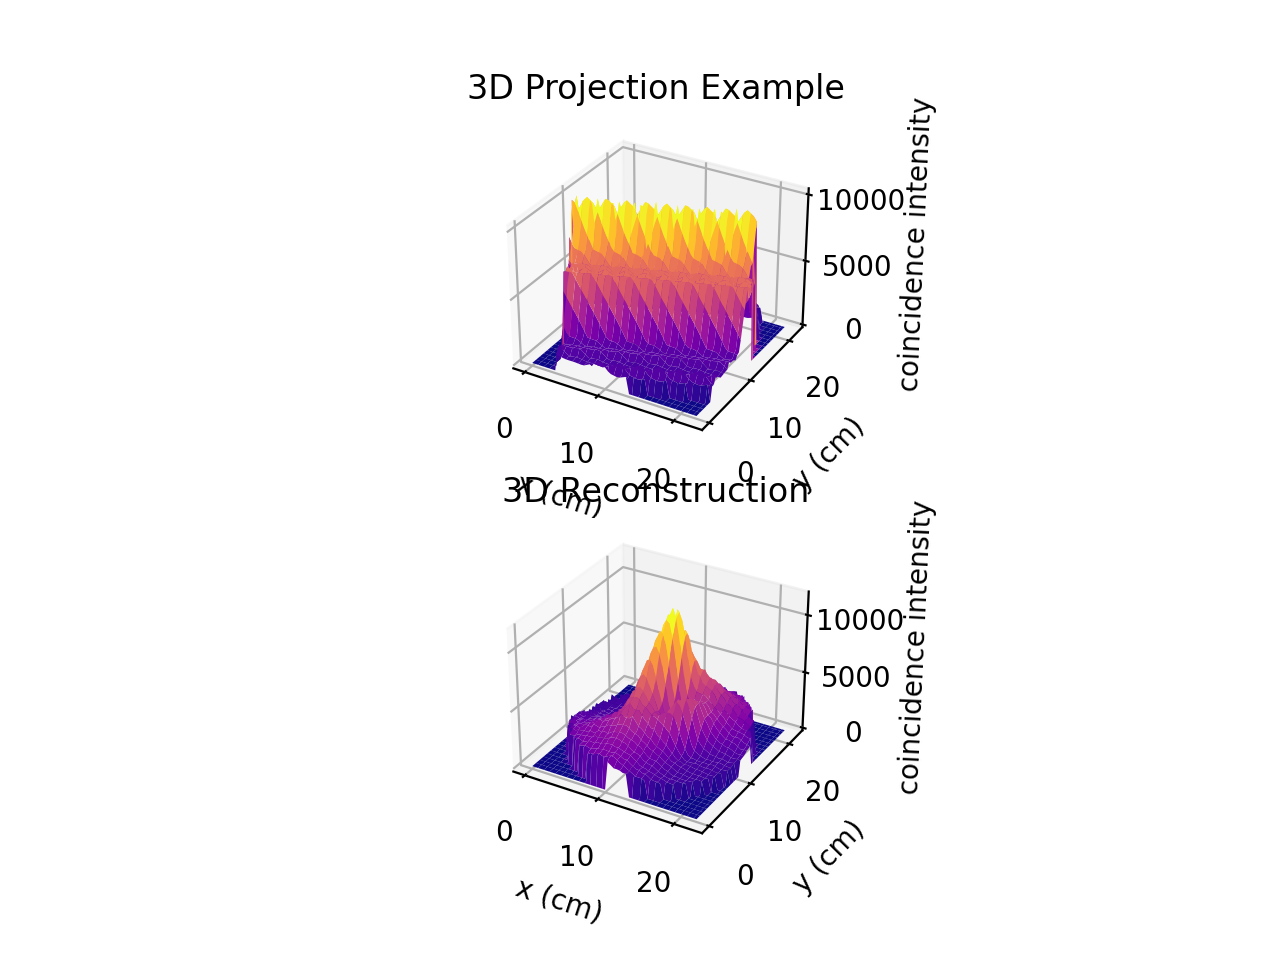

<IPython.core.display.Javascript object>


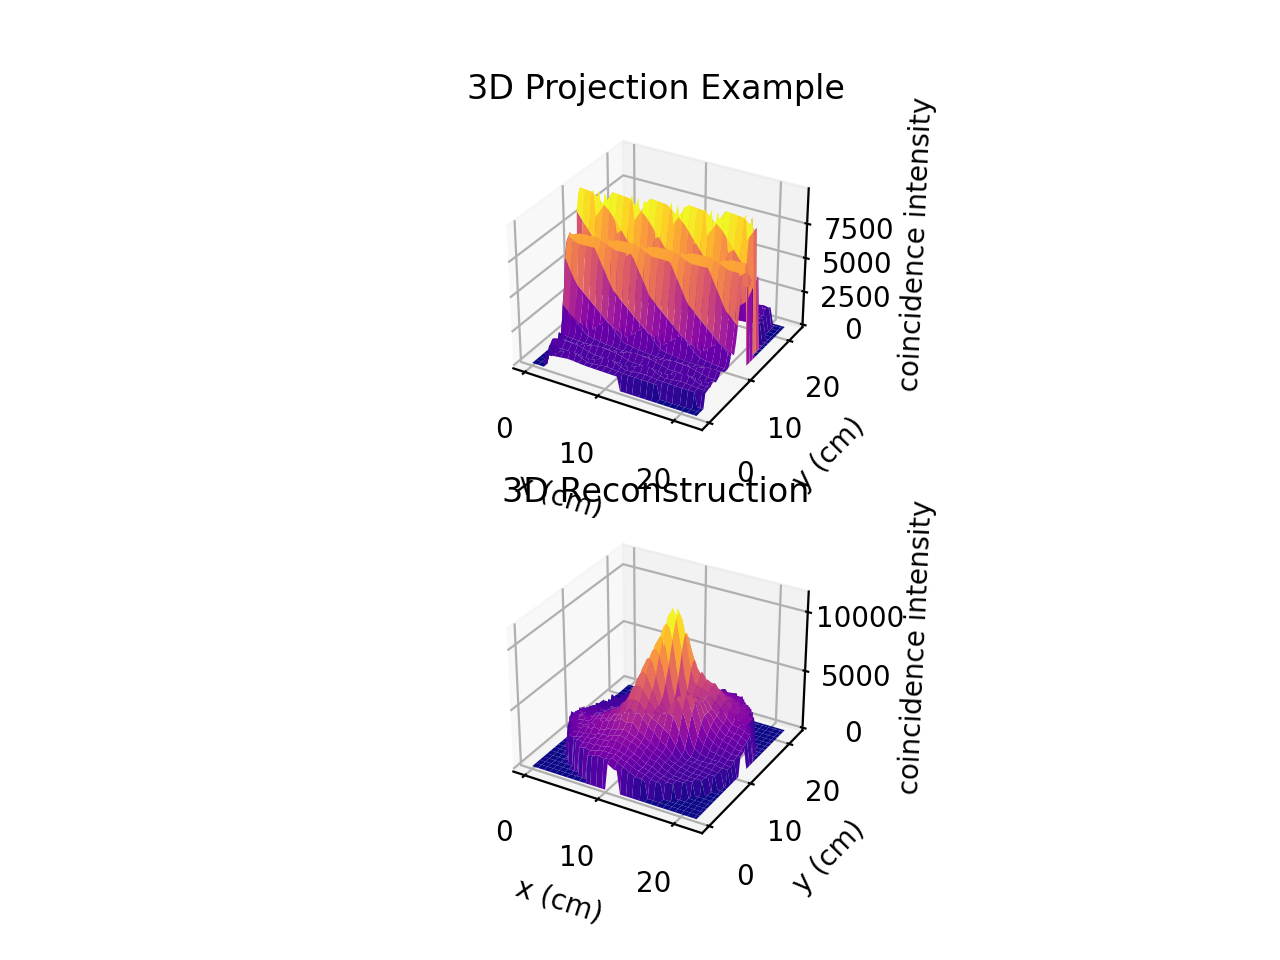

<IPython.core.display.Javascript object>


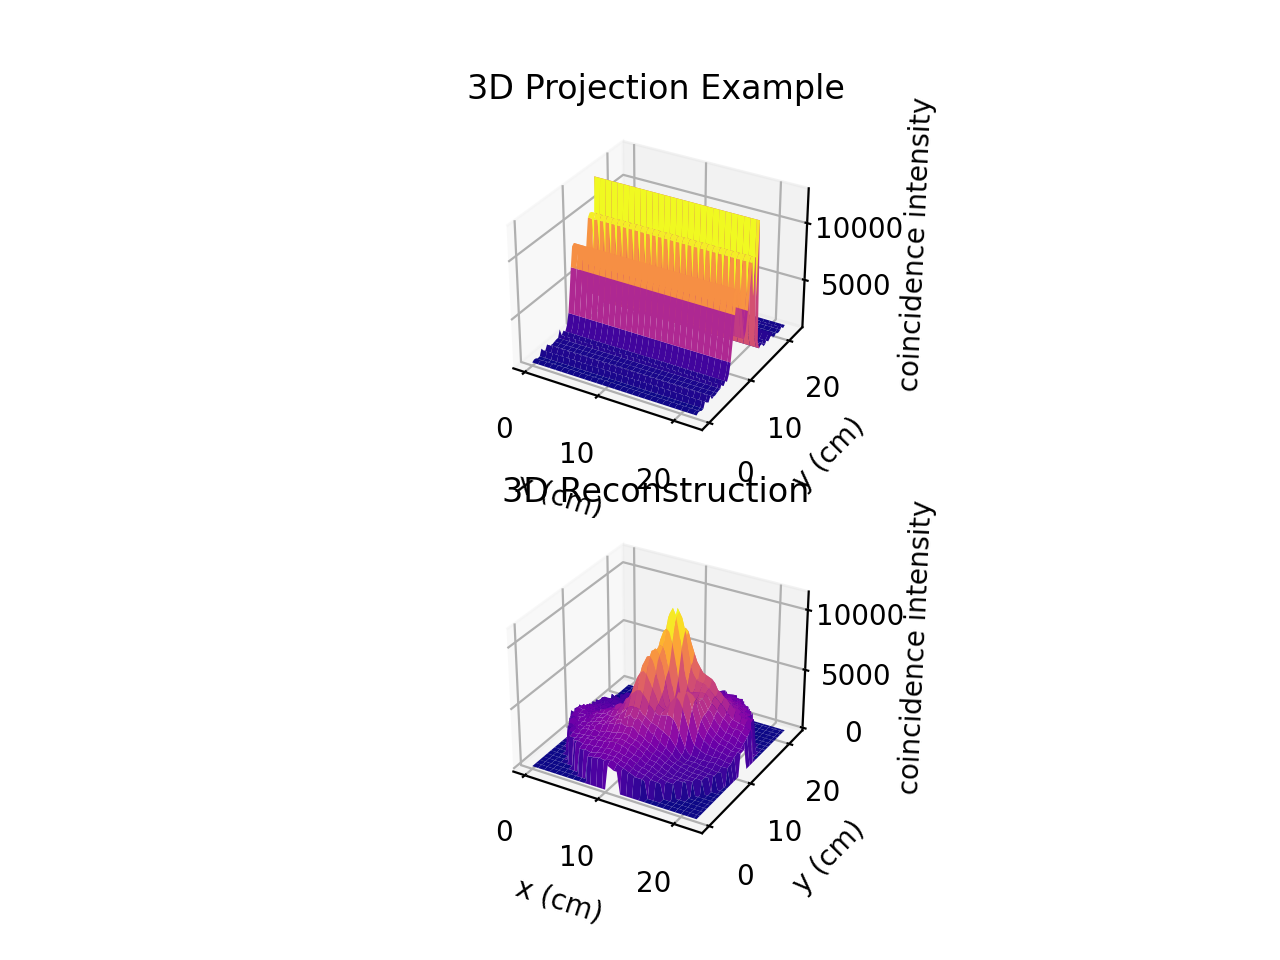

<IPython.core.display.Javascript object>


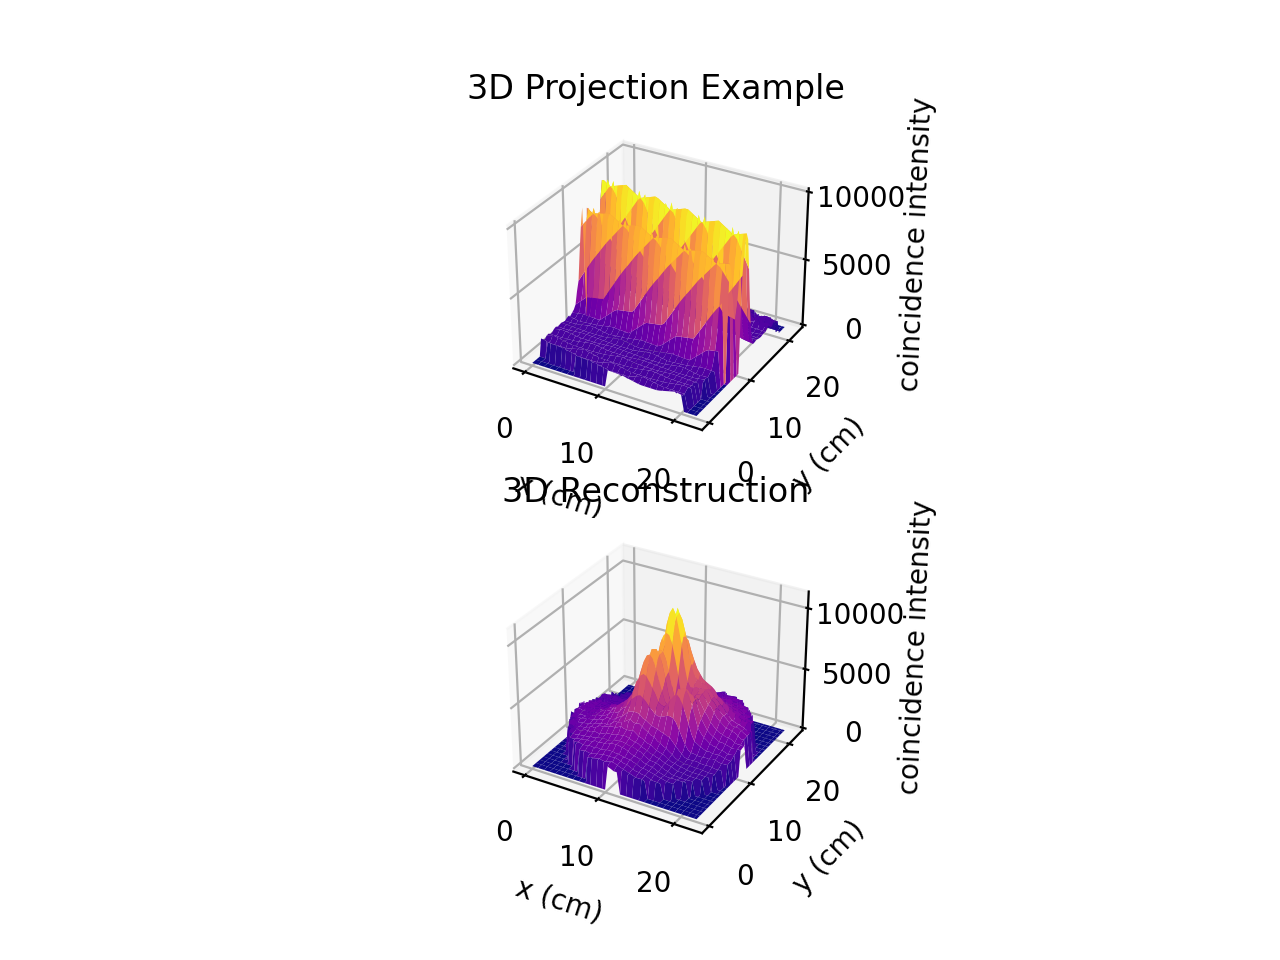

<IPython.core.display.Javascript object>


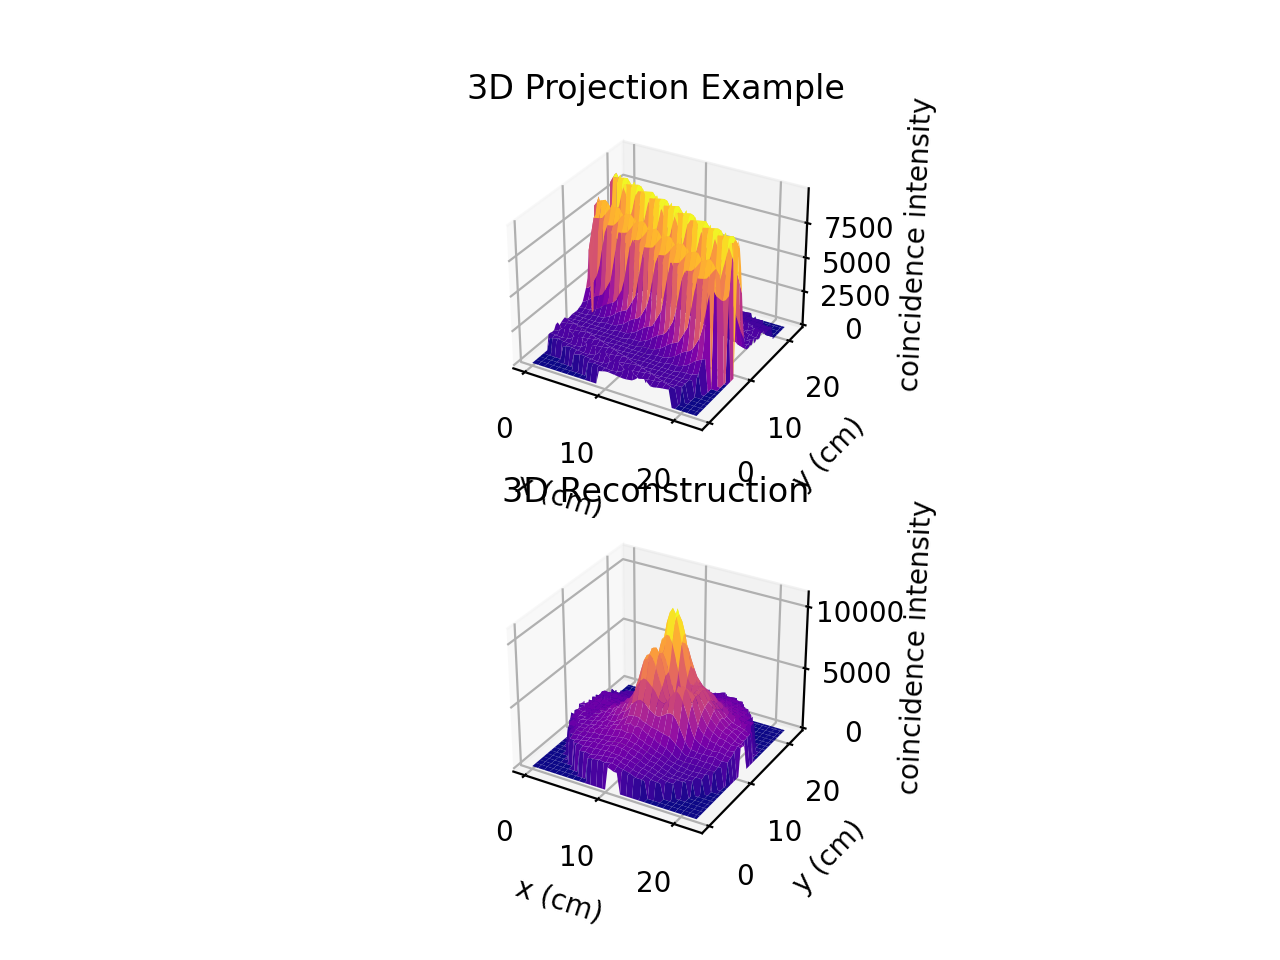

<IPython.core.display.Javascript object>


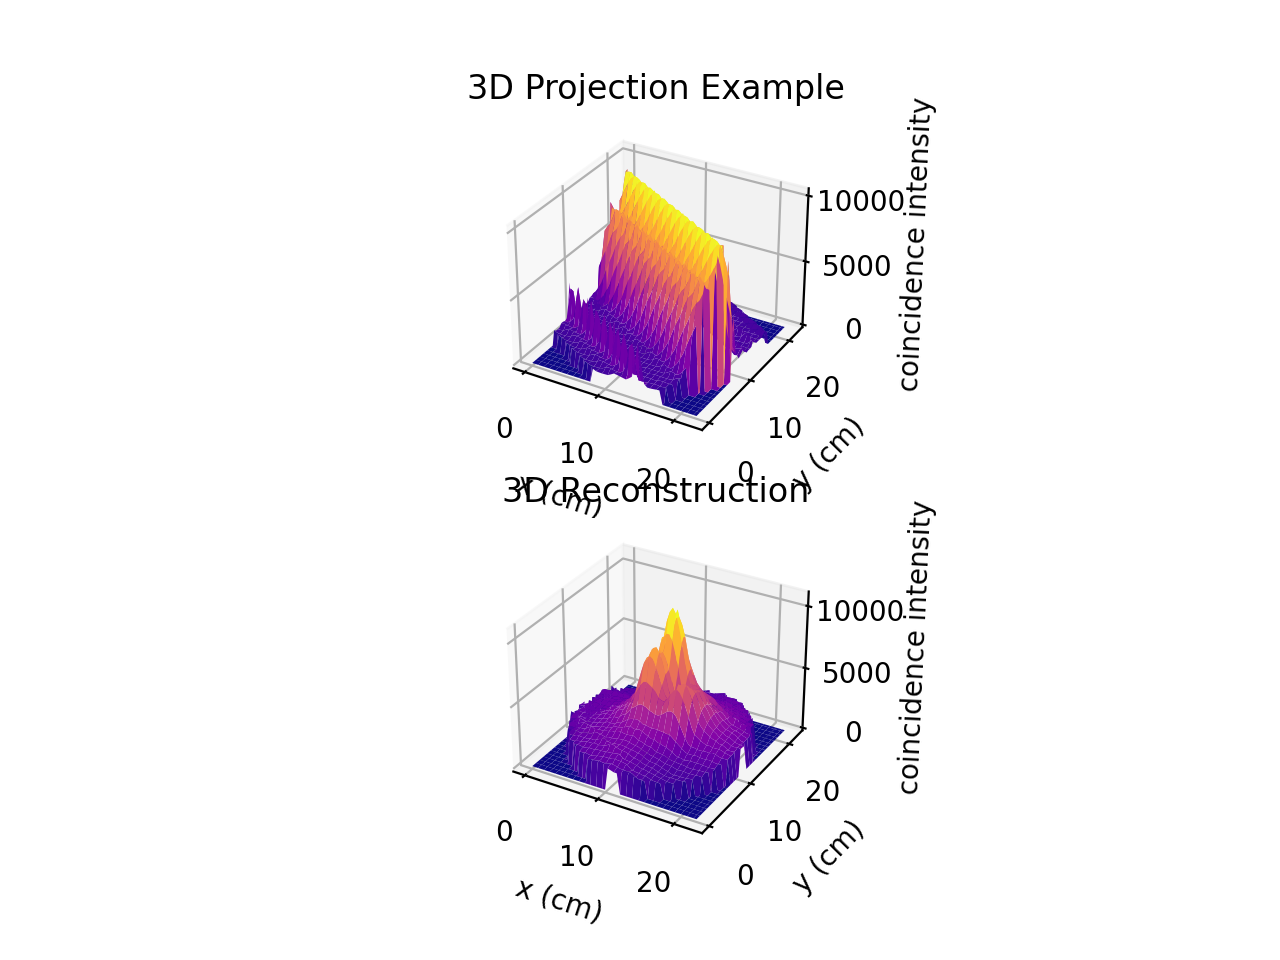

<IPython.core.display.Javascript object>


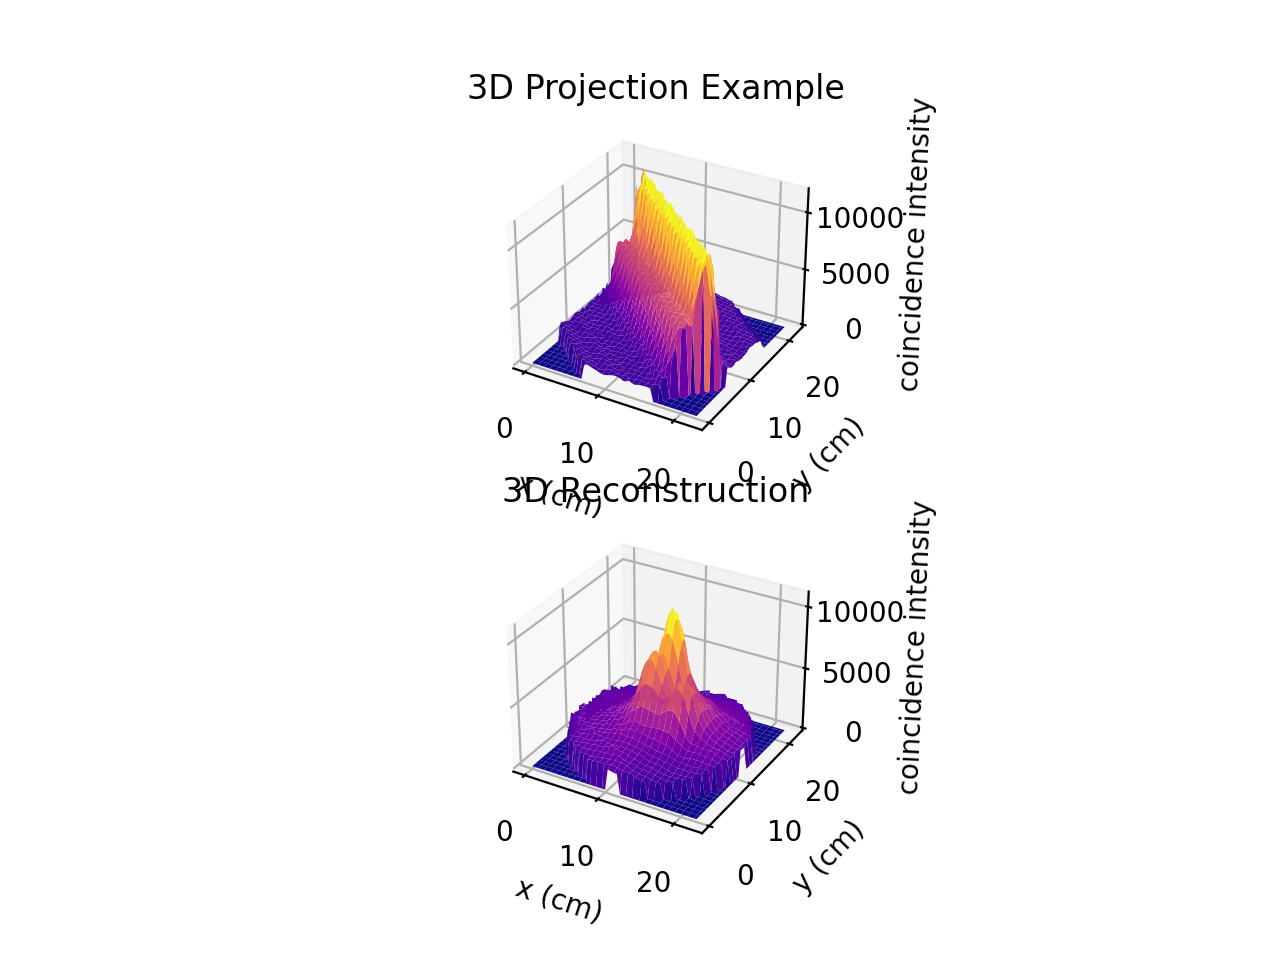

<IPython.core.display.Javascript object>


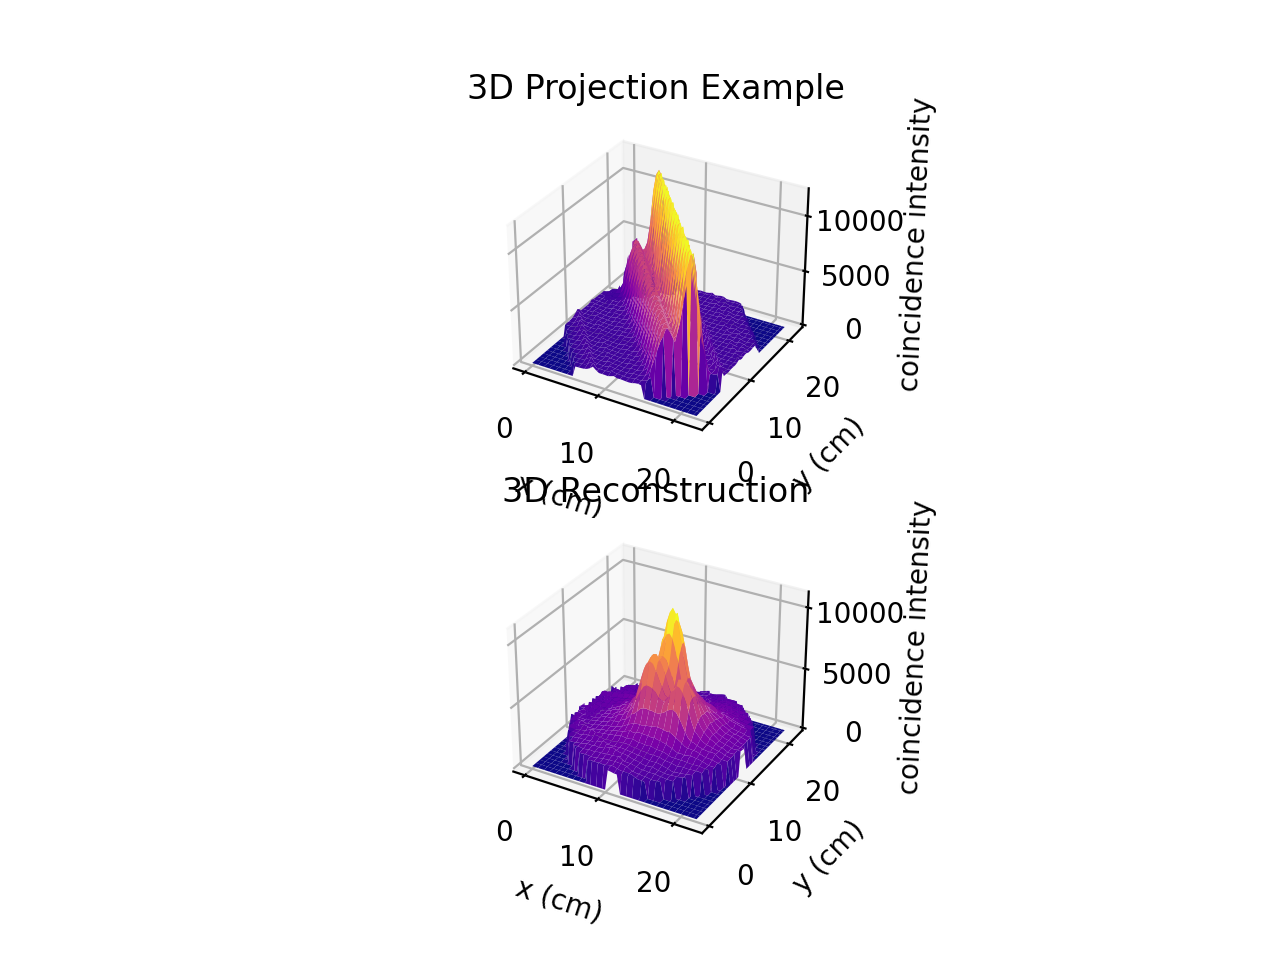

<IPython.core.display.Javascript object>


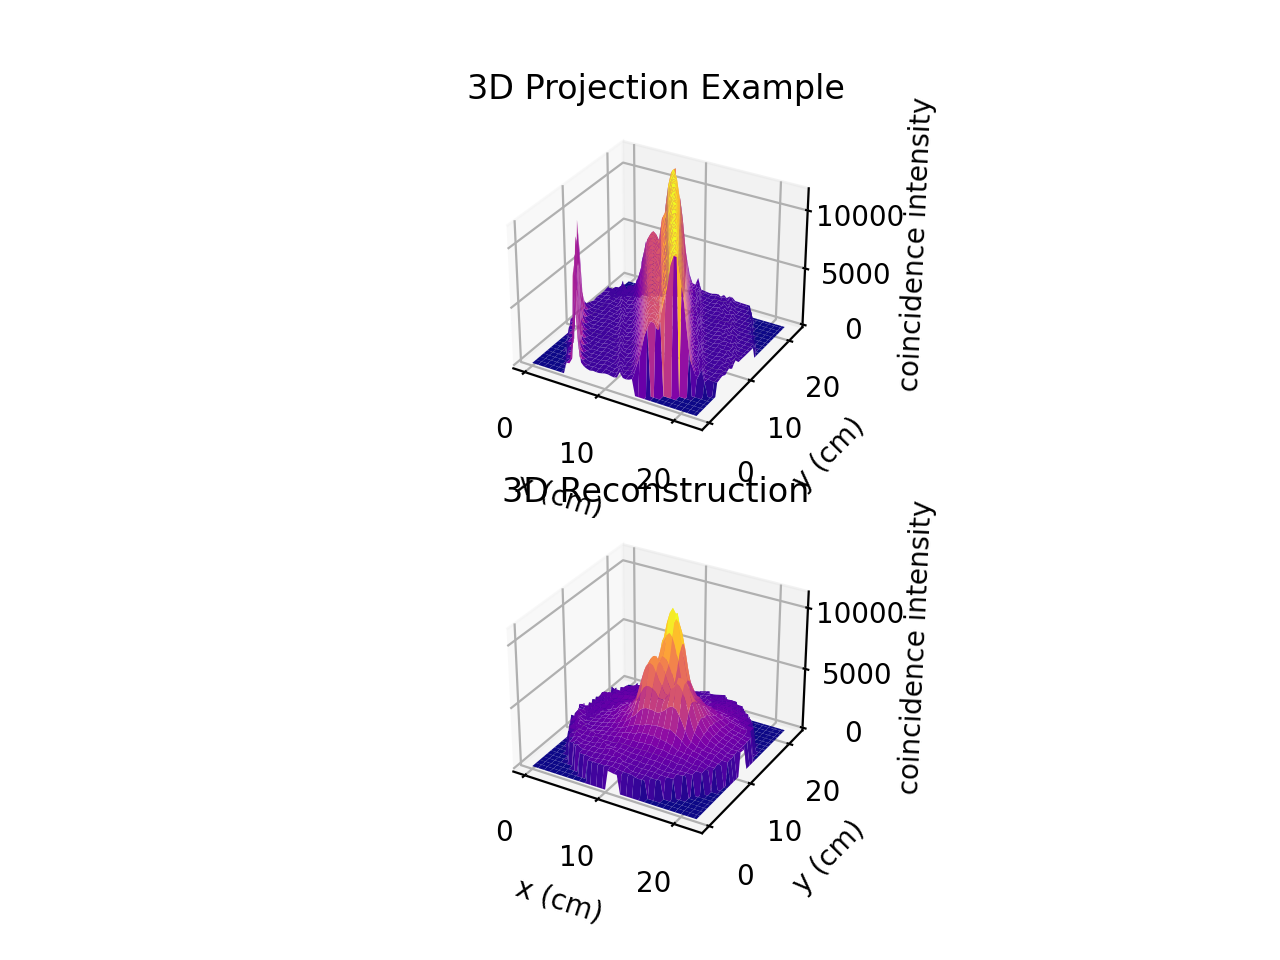

<IPython.core.display.Javascript object>


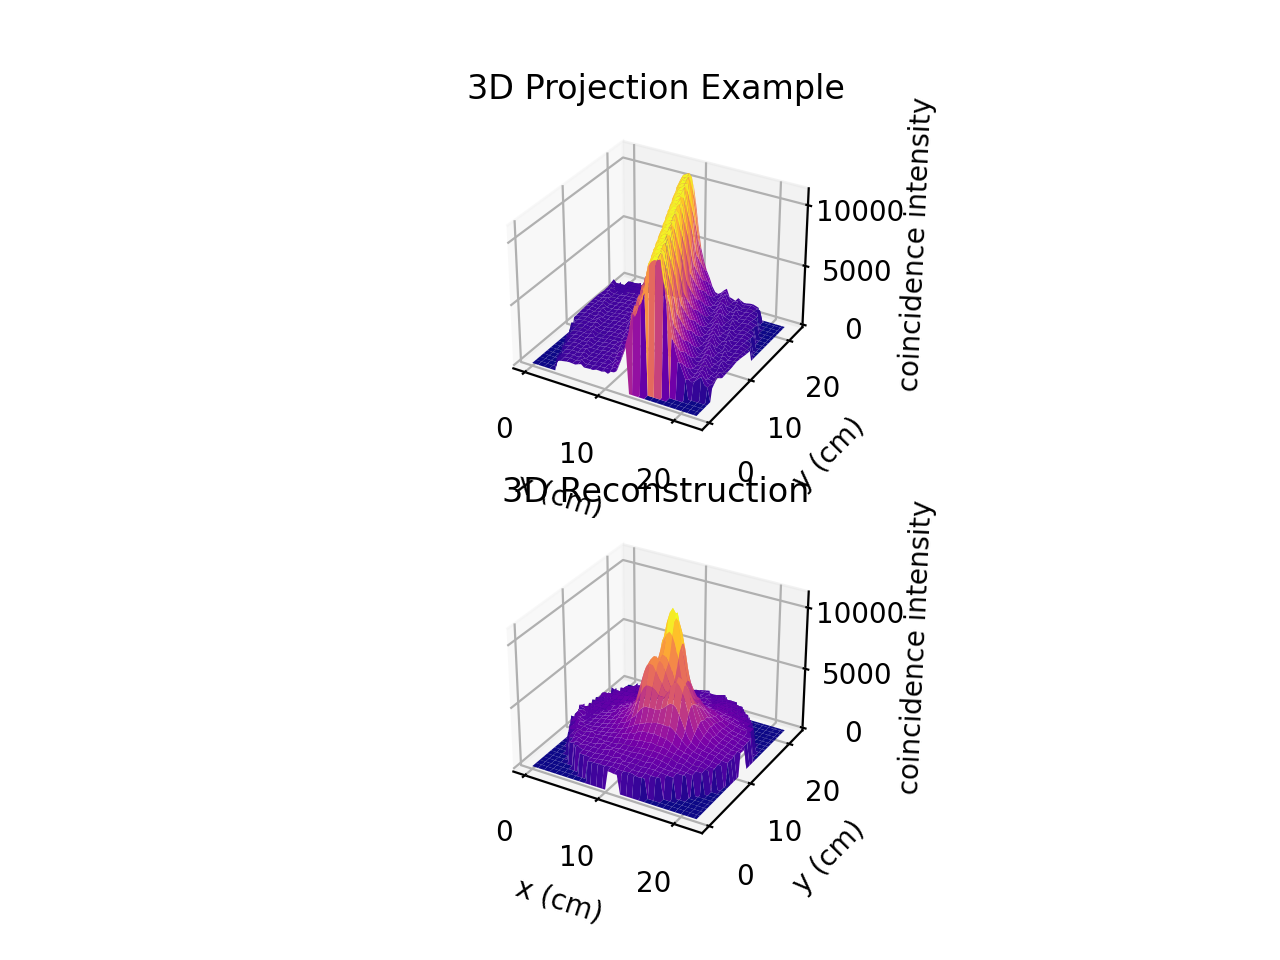

<IPython.core.display.Javascript object>


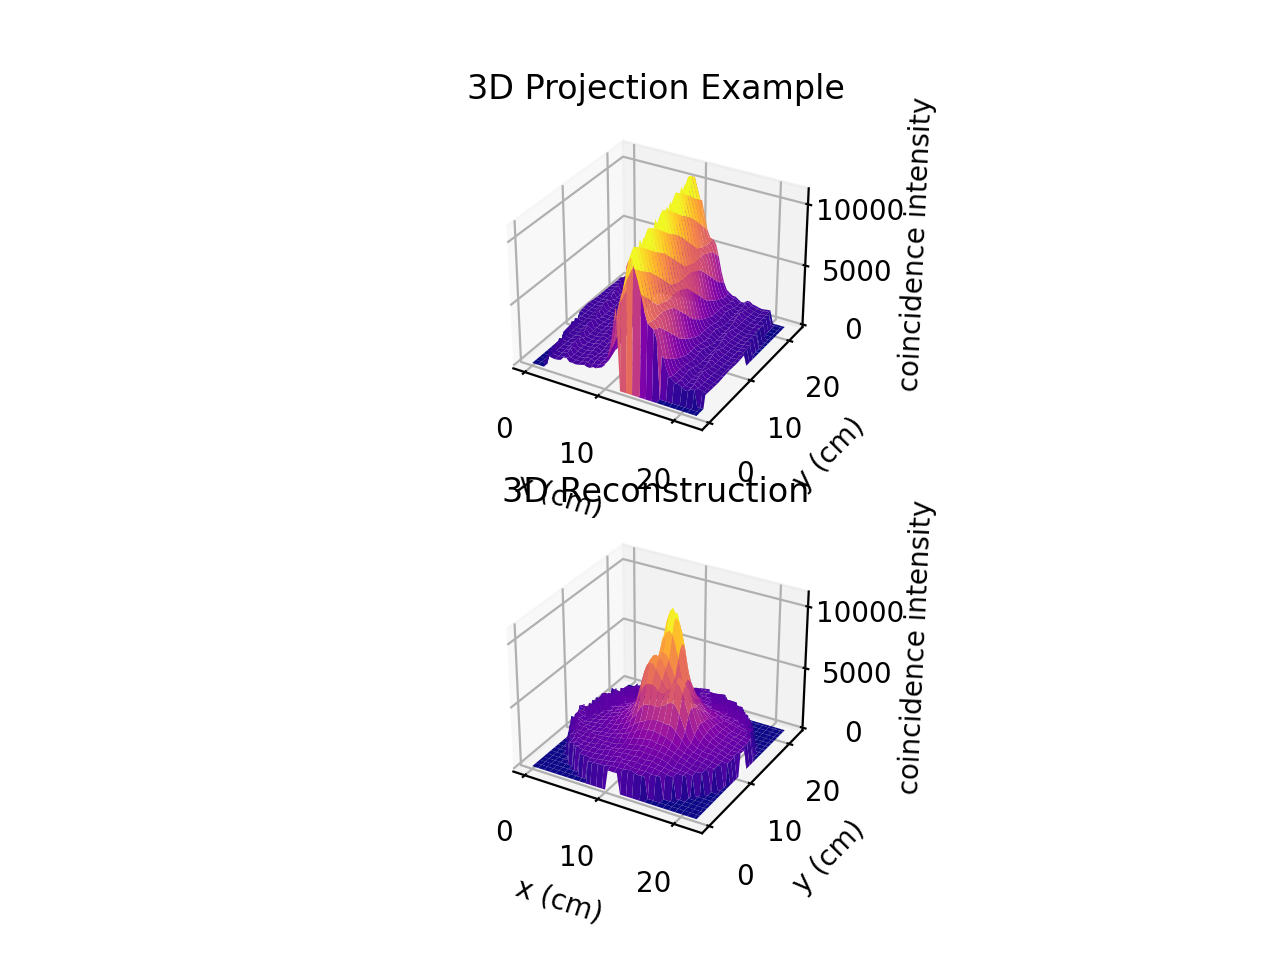

<IPython.core.display.Javascript object>


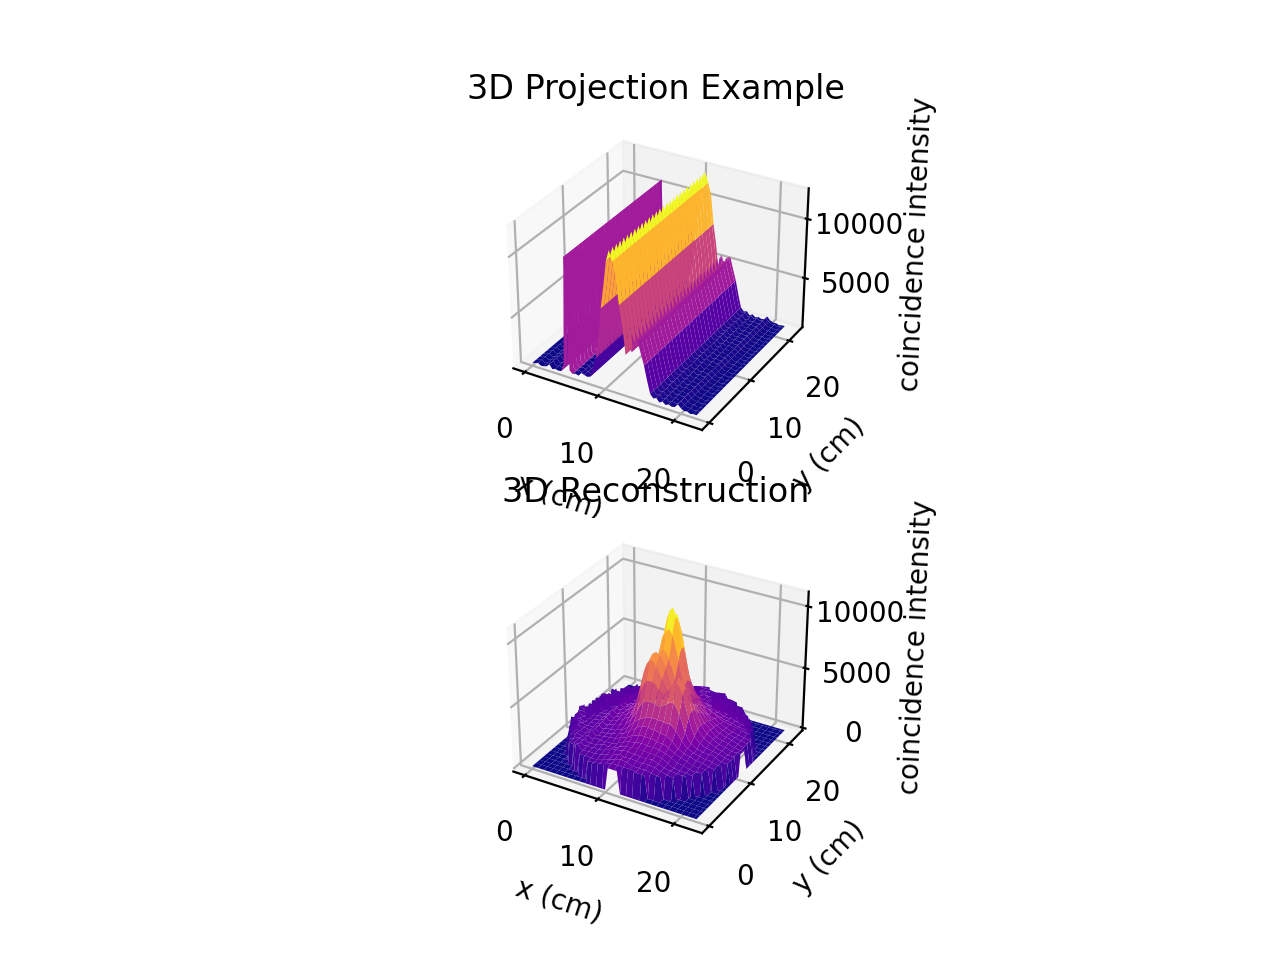

In [124]:
composite = np.ones_like(rotated_data[0]) 
for index, item in enumerate(rotated_data):
    fig = plt.figure()
    ax = fig.add_subplot(211, projection='3d')
    ay = fig.add_subplot(212, projection='3d')
    
    x = np.linspace(0,22,len(item)) 
    y = np.linspace(0,22,len(item))
    X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot
    
    ax.plot_surface(X, Y, item,cmap='plasma') #color maps are not required
    composite *= item   
    ay.plot_surface(X, Y, np.power(composite,(1/(index+1))),cmap='plasma') #color maps are not required
    
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    ax.set_zlabel('coincidence intensity')
    ax.set_title('3D Projection Example')
    
    ay.set_xlabel('x (cm)')
    ay.set_ylabel('y (cm)')
    ay.set_zlabel('coincidence intensity')
    ay.set_title('3D Reconstruction')

# Advanced Techniques
----
We can do a few things to improve our reconstruction technique here.  To start, let's see if we can do something about the jaggedness of the rotations.  We can do this by repeating values in the slices multiple times, so there's more space for interpolation.

There are any number of ways to accomplish this, and probably some better than this, but this will get the job done.

In [125]:
expansion_value = 2
expanded_slice = [np.array([])]
for index,slices in enumerate(data):
    for element in slices:  # This goes through each slice one item at a time
        repeat_values = np.full(expansion_value,element) # makex an x by 1 array full of one value
        expanded_slice[index] = np.append(expanded_slice[index], repeat_values) # This tacks on the expanded bit on the end of our array
    expanded_slice.append(np.array([])) # This adds a new empty array to the end of things
expanded_slice.pop()    #We accidentally create an extra empty array, so this gets rid of it
print(data[0])
print(expanded_slice[0])

[  974.    986.   1197.   1909.   1151.   1653.   1012.   1242.   1213.
   943.   1110.5  1327.   1360.   1006.   1129.   1156.   1041.   1113.
  1047.   1425.5  1188.   1305.   1902.   2535.   3791.   5465.   7750.
  9845.  11551.  13075.  11887.   9002.   6771.   3849.   3865.   4131.
  5570.   5413.   5101.   4264.   3494.   2156.   1301.   1484.   1236.
  1194.   1070.   1072.    988.   1026.   1068.   1040.    937.    969.
  1296.   1244. ]
[  974.    974.    986.    986.   1197.   1197.   1909.   1909.   1151.
  1151.   1653.   1653.   1012.   1012.   1242.   1242.   1213.   1213.
   943.    943.   1110.5  1110.5  1327.   1327.   1360.   1360.   1006.
  1006.   1129.   1129.   1156.   1156.   1041.   1041.   1113.   1113.
  1047.   1047.   1425.5  1425.5  1188.   1188.   1305.   1305.   1902.
  1902.   2535.   2535.   3791.   3791.   5465.   5465.   7750.   7750.
  9845.   9845.  11551.  11551.  13075.  13075.  11887.  11887.   9002.
  9002.   6771.   6771.   3849.   3849.   3865

The expanded_slice here is just the same values, but doubled up in the array.  Now we'll do our matrix expansion and rotation, and see what the difference is.

<IPython.core.display.Javascript object>


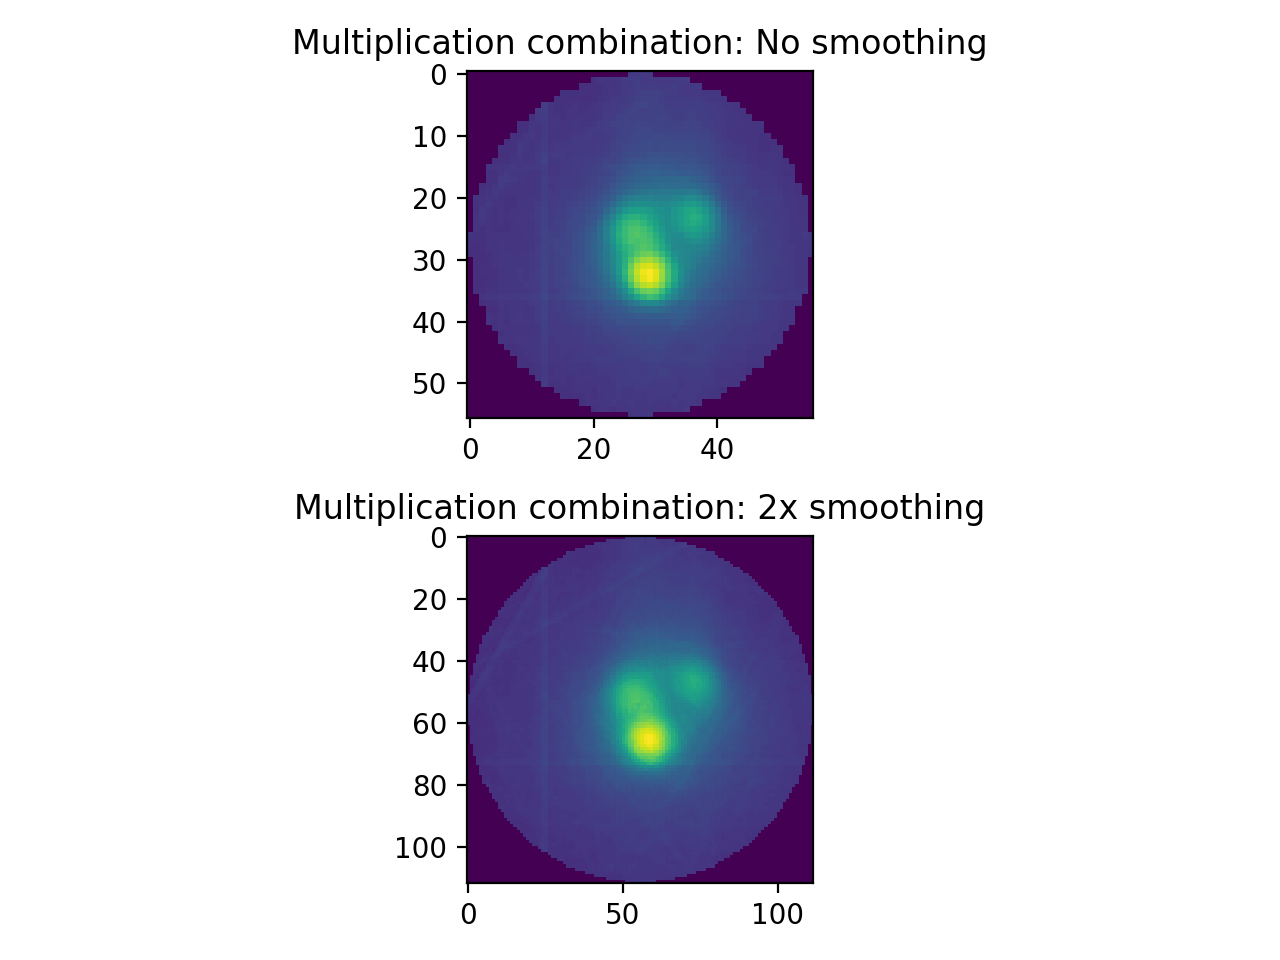

In [126]:
expand_vec = np.ones(expanded_slice[0].size)
expanded_rotation = []
for index, item in enumerate(expanded_slice):
    expanded_rotation.append(ndimage.rotate(np.outer(expand_vec,item),angles[index],reshape=False))

expanded_composite = np.ones_like(expanded_rotation[0])
for item in expanded_rotation:
    expanded_composite *= item
expanded_normalized = np.power(expanded_composite,(1/len(data)))

fig, (ax,ay) = plt.subplots(2)
ax.imshow(normalized)
ax.set_title("Multiplication combination: No smoothing")    
ay.imshow(expanded_normalized)
ay.set_title("Multiplication combination: 2x smoothing")
fig.tight_layout()

This does a lot to get rid of some of the jaggedness of the reconstruction, but there are also likely some shadows caused by us having multiple sources here.

We can also use a professional reconstruction technique: a [radon transform](https://en.wikipedia.org/wiki/Radon_transform).  At heart this technique uses a Fourier transform of slices, recombines these in a polar format, and then does an inverse Fourier transform.  You can try and work this out for yourself, but we can also use a package from `skimage` to do this for us with our data.  Since we're starting with slice/angle data, we'll be doing an inverse transformation.

You'll need to install the package in Anaconda for this to work.

In [128]:
from skimage.transform import iradon
reconstruction = iradon(np.transpose(np.array(data)),theta=np.array(angles)) 
# the transpose makes it line up with our other method

<IPython.core.display.Javascript object>


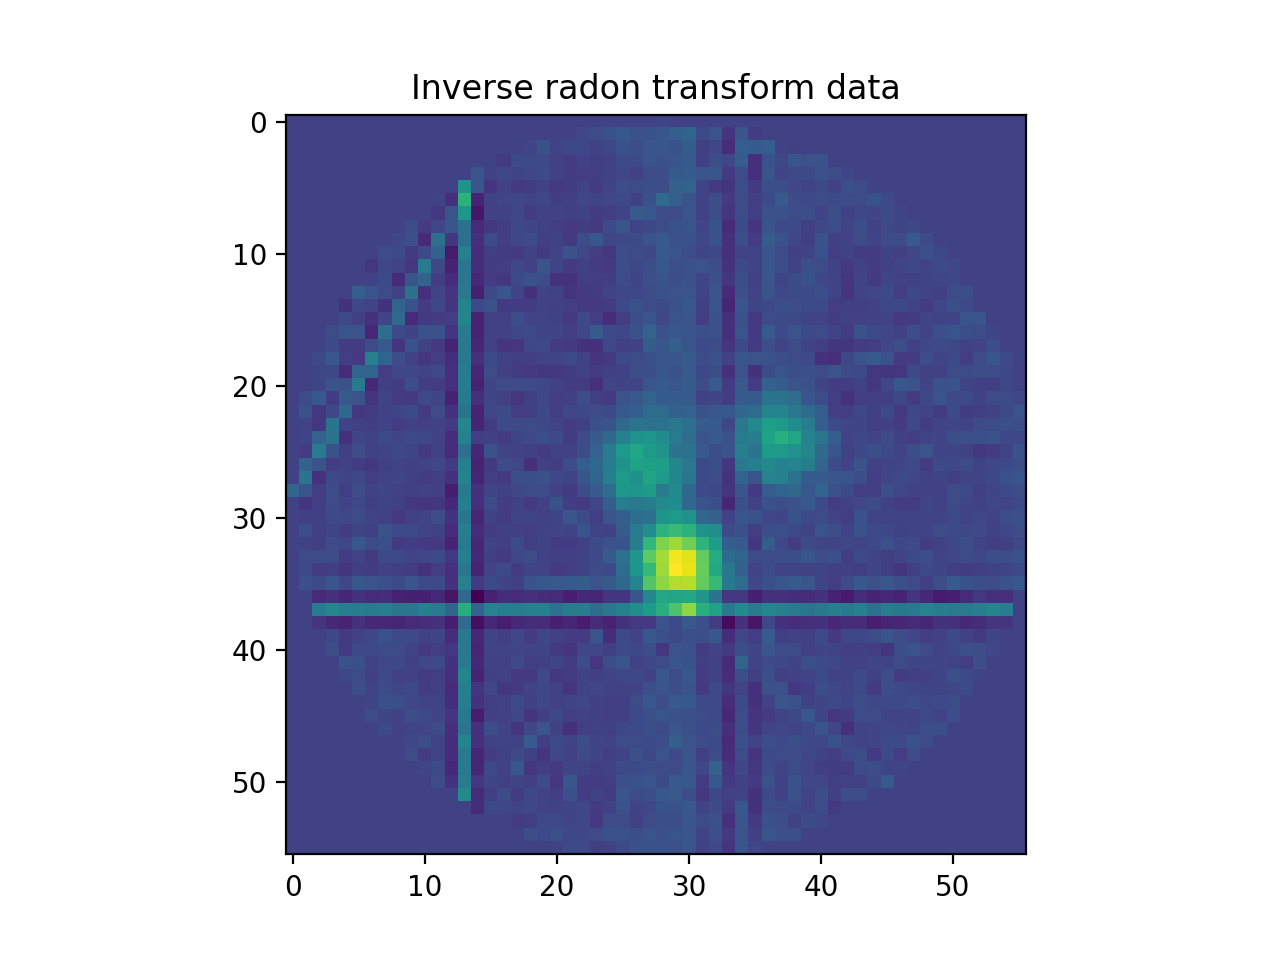

In [129]:
fig, ax = plt.subplots()
ax.imshow(reconstruction)
ax.set_title("Inverse radon transform data");

As expected the results are similar, but there are some differences in the intensities.